# **Project: Multitask Learning for Geometric Shape Classification and Counting**

## 1. Overview

In this project, you will design, implement, and evaluate a **multitask neural network** that performs **two tasks simultaneously**:

1. **Classification** – identify which pair of geometric shape types appears in a 28×28 binary image (135 possible configurations).
2. **Regression** – predict how many shapes of each type are present (6 regression targets).

This project focuses on **multi-task learning**, i.e., using one shared model to learn several related tasks at once. You will compare how adding an auxiliary task affects performance and training dynamics.

---

## 2. Dataset

You will use the **Geometric Shape Numbers (GSN)** dataset:

```bash
!wget https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip
```

This will create a directory `data/` containing:

* **10,000 images** (28×28x1, grayscale)
* **labels.csv** – counts of each of six shape types per image

Each image contains exactly **two types** of geometric figures (out of six) and **10 shapes total**.

**Shape classes:**

| Index | Shape type     |
| ----: | -------------- |
|     0 | square         |
|     1 | circle         |
|     2 | triangle up    |
|     3 | triangle right |
|     4 | triangle down  |
|     5 | triangle left  |

Example row from `labels.csv`:

```
name,squares,circles,up,right,down,left
img_00000.png,0,0,0,4,0,6
```

Here, the image contains **4 right-pointing triangles** and **6 left-pointing triangles**.

**Split:**

* Training: first 9,000 samples
* Validation: last 1,000 samples

Examples:
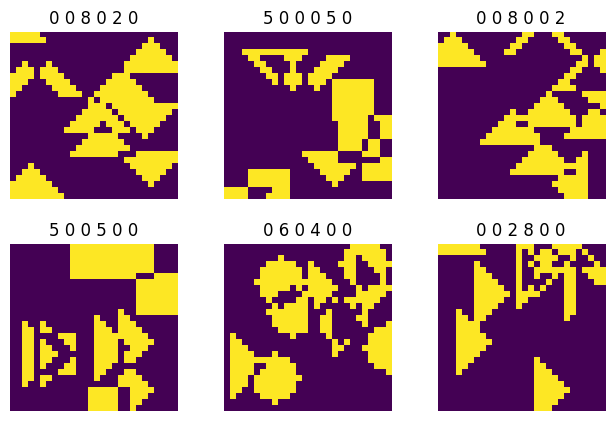

---

## 3. Tasks and objectives

You must design a **multitask deep learning system** that:

1. **Classifies** each image into one of **135 possible configurations**, representing:

   * which **two shape classes** appear, and
   * how their counts (1–9) sum to 10.

   → Example: "3 circles + 7 squares" is one configuration class.

2. **Regresses** the number of shapes of each type (a 6-dimensional real-valued output).

3. Combines both objectives in a **joint loss** function (Hint: losses are implemented in PyTorch):


$$ Loss = \text{NLLLoss(classification)} + \lambda_{\text{cnt}} \cdot \text{SmoothL1Loss(regression)}
$$

---

## 4. Model requirements

### Architecture constraints

You must use **exactly this feature extractor (backbone)**:

```python
nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(64 * 28 * 28, 256), nn.ReLU()
)
```

Then add **two separate heads**:

* `head_cls`: outputs log-probabilities for 135 classes
* `head_cnt`: outputs 6 regression values (counts)

The model must return two outputs: `(log_probs, counts)`.

You may add dropout or batch normalization inside the heads, **but you must not modify the backbone**.

---

## 5. Training setup

* Optimizer: **Adam**, learning rate = 1e-3
* Epochs: up to **100** (use **early stopping**)
* Batch sizes: **64** (train), **1000** (validation)
* Device: GPU allowed for Notebook, but your **final code must run on GPU within ~30 minutes**
* Random seed: set `torch.manual_seed(1)` for reproducibility
* Split: **exactly 9,000 train / 1,000 validation**


---

## 6. Data preprocessing and augmentation

You must implement a **PyTorch `Dataset` class** that:

* Reads `labels.csv`
* Loads the corresponding image (from `data/`)
* Returns both:
  * the image (as a tensor)
  * the labels (counts for 6 shapes)
* Optionally applies transformations

### Required augmentations

You must implement **at least three** of the following:

1. Random horizontal flip
2. Random vertical flip
3. Random 90° rotation (must correctly rotate orientation labels: up → right → down → left)
4. Random brightness/contrast (mild)
5. Gaussian noise
6. Random erasing (small areas only)


---

## 7. Evaluation metrics

Implement and report the following metrics on the validation set:

### (a) **Classification (135-way)**

* Top-1 accuracy
* Macro F1-score
* Per-pair accuracy (aggregate by unordered shape pair, e.g. {circle, up})

### (b) **Regression (6-D counts)**

* RMSE per class and overall
* MAE per class and overall

Also plot:

* Training and validation losses
* Validation accuracy and RMSE over epochs

**Important**: This task is not about finding the best architecture; we expect at least 50% accuracy, but achieving results higher than that will not affect the grade for the assignment**.


---

## 8. Experiments and analysis

You must train and compare **three model settings**:

| Setting | Description                                      |
| :------ | :----------------------------------------------- |
| 1       | **Classification-only:** λ_cnt = 0               |
| 2       | **Regression-only:** classification loss ignored |
| 3       | **Multitask:** λ_cnt = with your choose          |

For each experiment:

* Train until early stopping
* Record loss, accuracy, RMSE, and runtime
* Compare results and explain how λ influences learning
* Discuss whether multitask learning improves the main tasks


---

## 9. Final deliverables

You must submit .zip project with:

1. **Code** (`.ipynb` or `.py`) that:

   * Downloads and extracts the dataset
   * Defines dataset, dataloaders, model, loss, training loop, evaluation, and plotting
   * Can run start-to-end without interaction, and finishes within 30 minutes on Colab T4 GPUs
   * Includes three experiment configurations

2. **Report (2–4 pages, PDF)** including:
   * Section on (EDA) Exploratory Data Analysis in your report: no more than 3 graphs or tables describing the data set.
   * Model architecture
   * Description and justification of augmentations
   * Results table (loss, accuracy, RMSE for all runs)
   * Learning curves
   * Discussion on multitask effects

3. **README.md**:

   * Link to Colab version of task for fast replication.
   * Approximate runtime and resource requirements

---

## 10. Grading rubric

Component	Description	Points
1. Implementation correctness	Correct use of the fixed backbone, two-headed model, and proper training loop (classification + regression).	30%
2. Data & augmentations	Proper dataset loading, preprocessing, and at least three augmentations with brief justification.	20%
3. Evaluation & experiments	Correct computation of metrics (accuracy, F1, RMSE) and completion of all three λ configurations (λ=0, regression-only, your choice λ).	30%
4. Report & analysis
A clear separation of concerns (e.g. headers in notebooks, modules in code) and concise 2–4 page report with results tables, learning curves, confusion matrix, and short discussion on multitask effects and error examples.
20%

###### Readability and modularity will be considered within each grading component. Clear structure (headers in notebooks, docstrings, modular code) significantly improves evaluation speed. Emphasize using clear headers to help reviewers navigate efficiently.
---

In [3]:
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip

from pathlib import Path
from PIL import Image
import torch
import torch.nn
from torch import Tensor
from typing import cast
from torchvision.transforms import v2
import numpy as np
import torchvision.transforms as T
import PIL
import pandas as pd
from torchvision import transforms




--2025-11-24 21:14:48--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-24 21:14:49--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.05s   

2025-11-24 21:14:49 (116 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1)

directory_in_str = "data"
class RandomHorizontalFlip(torch.nn.Module): # here define it for both the img and the label, which itsel is just a list
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img, label: np.ndarray):
        imgNew = img.copy()
        labelNew = label.copy()
        if torch.rand(1) < self.p:
            imgNew =  T.functional.hflip(imgNew)
            placeHold = labelNew[5]
            labelNew[5] = labelNew[3]
            labelNew[3] = placeHold

        return imgNew, labelNew


class RandomVerticalFlip(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img, label: np.ndarray):
        imgNew = img.copy()
        labelNew = label.copy()
        if torch.rand(1) < self.p:

            imgNew =  T.functional.hflip(imgNew)
            placeHold = labelNew[2]
            labelNew[2] = labelNew[4]
            labelNew[4] = placeHold

        return imgNew, labelNew

class Random90DegFlip(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img, label: np.ndarray):
        imgNew = img.copy()
        labelNew = label.copy()
        if torch.rand(1) < self.p:
            imgNew =  T.functional.rotate(imgNew,90)
            plcHoldUp = labelNew[2]
            plcHolLeft = labelNew[5]
            plcHolDown = labelNew[4]
            plcHolRight = labelNew[3]

            labelNew[2] = plcHolLeft # 2 becomes 5
            labelNew[3] = plcHoldUp # 3 becomes 2
            labelNew[4] = plcHolRight # 4 becomes 3
            labelNew[5] = plcHolDown # 5 becomes 4
        return imgNew, labelNew


indexDict = {
    "01":0,
    "02":1,
    "03":2,
    "04":3,
    "05":4,
    "12":5,
    "13":6,
    "14":7,
    "15":8,
    "23":9,
    "24":10,
    "25":11,
    "34":12,
    "35":13,
    "45":14
}

valDict = {
    "19":0,
    "28":1,
    "37":2,
    "46":3,
    "55":4,
    "64":5,
    "73":6,
    "82":7,
    "91":8,
}

def listToNum(y):
  # here y is [0,0,3,7,0,0]
  val1,val2,i1,i2 = -1,-1,-1,-1
  for i in range(6):
    if y[i] != 0:
      if val1 == -1:
        val1 = y[i]
        i1 = i
      else:
        val2 = y[i]
        i2 = i
  ixPair = str(int(i1)) + str(int(i2))
  ixVal = indexDict[ixPair]

  valPair = str(int(val1)) + str(int(val2))
  valVal = valDict[valPair]
  finalIx = ixVal * 9 + valVal
  #print("Y: ",y)
  #print("ixPair and valPair: ",ixVal,valVal)
  #print("final index: ", finalIx)

  return finalIx



class MyDataset(torch.utils.data.Dataset):
  def __init__(self,X,Y):
    self.X = X
    self.Y = Y
    self.Random90DegFlip = Random90DegFlip()
    self.RandomVerticalFlip = RandomVerticalFlip()
    self.RandomHorizontalFlip = RandomHorizontalFlip()
  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    X,Yr = self.X[idx], self.Y[idx]


    X,Yr = self.Random90DegFlip(X,Yr)
    X,Yr = self.RandomVerticalFlip(X,Yr)
    X,Yr = self.RandomHorizontalFlip(X,Yr)
    X = T.functional.to_tensor(X)
    Yc = listToNum(Yr)
    Yr,Yc = torch.tensor(Yr), torch.tensor(Yc)
    return X,Yc,Yr


def tensorToPil(image: Tensor) -> PIL.Image.Image:
  img = T.functional.to_pil_image(image)
  return img


class MyDatasetClassification(torch.utils.data.Dataset):
  def __init__(self,X,Y):
    self.X = X
    self.Y = Y
    self.Random90DegFlip = Random90DegFlip()
    self.RandomVerticalFlip = RandomVerticalFlip()
    self.RandomHorizontalFlip = RandomHorizontalFlip()

  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    X,Y = self.X[idx], self.Y[idx]
    '''
    X,Y = self.Random90DegFlip(X,Y)
    X,Y = self.RandomVerticalFlip(X,Y)
    X,Y = self.RandomHorizontalFlip(X,Y)
    '''
    X = T.functional.to_tensor(X)
    #Y = listToNum(Y)
    X,Y = torch.tensor(X), torch.tensor(Y)
    return X,Y


def tensorToPil(image: Tensor) -> PIL.Image.Image:
  img = T.functional.to_pil_image(image)
  return img




class ModelCombined(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.bb = torch.nn.Sequential(
    torch.nn.Conv2d(1, 8, 3, stride=1, padding=1), torch.nn.ReLU(),
    torch.nn.Conv2d(8, 16, 3, stride=1, padding=1), torch.nn.ReLU(),
    torch.nn.Conv2d(16, 32, 3, stride=1, padding=1), torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, 3, stride=1, padding=1), torch.nn.ReLU(),
    torch.nn.Flatten(start_dim=1),
    torch.nn.Linear(64 * 28 * 28, 256), torch.nn.ReLU()
)
    self.classPart = torch.nn.Sequential(
        torch.nn.BatchNorm1d(256),
        torch.nn.Linear(256,256),
        torch.nn.Sigmoid(),
        torch.nn.Linear(256,135),
        torch.nn.LogSoftmax(dim=1)
    )
    self.regPart = torch.nn.Sequential(
        torch.nn.BatchNorm1d(256),
        torch.nn.Linear(256,6),
        torch.nn.ReLU()
    )


  def forward(self,x):
    x = self.bb(x)
    return self.classPart(x), self.regPart(x) # use the same head backbone, output two different things


def train(model, device, trainLoader,opt, epoch,logInterv):
  model.train()
  for batch_idx, (data, targetC,targetR) in enumerate(trainLoader):
    data, targetC,targetR = data.to(device), targetC.to(device),targetR.to(device)
    opt.zero_grad()
    outputC, outputR = model(data)
    #print("dziala 1")
    #print("OUTPUT 2 and TARGET 2: ", outputC.shape, targetC.shape, outputR.shape,targetR.shape)
    lossC = torch.nn.functional.nll_loss(outputC,targetC)
    #print("dziala 2 ")
    lossR = torch.nn.functional.smooth_l1_loss(outputR,targetR)


    loss = 0.7 * lossC   +  0.3 * lossR # let's try linear loss at first
    loss.backward()


    opt.step()


    if batch_idx % logInterv == 0:
      done, total = batch_idx * len(data) , len(trainLoader.dataset)
      print(
          f"Train Epoch: {epoch}, [{done}/{total} images ({done / total:.0%})] \t"
          + f"loss {loss.item():.6f}" + f" Partial Loss: {lossC.item():.6f}" + f" LossR: {lossR.item():.6f}"
      )


def test(model, device, trainLoader, epoch, logInterv):
  model.eval()
  testLoss = 0
  total = 0
  correctR = 0

  correctC = 0
  with torch.no_grad():
    for data, targetC, targetR in trainLoader:
      data, targetC, targetR = data.to(device), targetC.to(device), targetR.to(device)
      outputC,outputR = model(data)
      #print("OUTPUT: ", outputR," TARGET: ", targetR)
      loss = 0.5 * torch.nn.functional.nll_loss(outputC,targetC) + 0.5 * torch.nn.functional.smooth_l1_loss(outputR,targetR)
      testLoss += loss

      outputC = outputC.argmax(dim=1) # this outputs C numbers, so our predictions
      #print("Target C: ", targetC, " output c: ", outputC)

      correctR += (outputR == targetR).sum().item()
      total += trainLoader.batch_size

      correctC += (outputC == targetC).sum().item()

    testLoss /= total

    print(f"Test loss: {testLoss}, For classification: {correctC} / {total}, Regression: {correctR} / {total}" )



class ModelClass(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.bb = torch.nn.Sequential(
      torch.nn.Conv2d(1, 8, 3, stride=1, padding=1), torch.nn.ReLU(),
      torch.nn.Conv2d(8, 16, 3, stride=1, padding=1), torch.nn.ReLU(),
      torch.nn.Conv2d(16, 32, 3, stride=1, padding=1), torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, 3, stride=1, padding=1), torch.nn.ReLU(),
      torch.nn.Flatten(start_dim=1),
      torch.nn.Linear(64 * 28 * 28, 256), torch.nn.ReLU()
)
    self.head = torch.nn.Sequential(
        torch.nn.BatchNorm1d(256),
        torch.nn.Linear(256,256),
        torch.nn.Sigmoid(),
        torch.nn.Linear(256,135),
        torch.nn.LogSoftmax(dim=1)
    )
  def forward(self,x):
    x = self.bb(x)
    x = self.head(x)
    return x

def trainClass(model, device, trainLoader,opt, epoch,logInterv):
  model.train()
  for batch_idx, (data, targetC) in enumerate(trainLoader):
    data, targetC = data.to(device), targetC.to(device)
    opt.zero_grad()
    outputC = model(data)
    #print("Given input: ", outputC.shape, "and required output: ",targetC.shape)


    #outputC = outputC.long()
    targetC = targetC.long()
    lossC = torch.nn.functional.nll_loss(outputC,targetC)


    lossC.backward()

    opt.step()


    if batch_idx % logInterv == 0:
      done, total = batch_idx * len(data) , len(trainLoader.dataset)
      print(
          f"Train Epoch: {epoch}, [{done}/{total} images ({done / total:.0%})] \t"
          + f" Partial Loss: {lossC.item():.6f}"
      )


def testClass(model, device, trainLoader, epoch, logInterv):
  model.eval()
  testLoss = 0
  total = 0
  correctR = 0

  correctC = 0
  with torch.no_grad():
    for data, targetC in trainLoader:

      data, targetC = data.to(device), targetC.to(device)
      outputC = model(data)
      targetC = targetC.long()

      loss = torch.nn.functional.nll_loss(outputC,targetC)
      testLoss += loss


      outputC = outputC.argmax(dim=1)
      print("Output shape: ",outputC.shape, " and targ :", targetC.shape)


      total += trainLoader.batch_size

      correctC += (outputC == targetC).sum().item()

    testLoss /= total

    print(f"Test loss: {testLoss}, For classification: {correctC} / {total}" )
pathlist = Path(directory_in_str).glob('**/*.png')
X = [0] * 10000

for path in pathlist: # let's extract each of the 10000 images into one big tensor, our sample dataset, X
    path_in_str = str(path)
    index = path_in_str[-9:-4]

    index = int(index)

    img = Image.open(path_in_str).convert("L")
    X[index] = img # as such, image 00000 resides in X[0]



csvFile = pd.read_csv("data/labels.csv")
Y = csvFile.values[:,1:].astype(np.float32)

XTrainReg = X[:8000]
YTrainReg = Y[:8000]

XValReg = X[8000:]
YValReg = Y[8000:]


XTrainClass = XTrainReg.copy()
YTrainClass = [0] * 8000

XValClass = XValReg.copy()
YValClass = [0] * 2000

for i in range(8000):
  YTrainClass[i] = listToNum(YTrainReg[i])

for i in range(2000):
  YValClass[i] = listToNum(YValReg[i])


trainDatasetC = MyDatasetClassification(XTrainClass,YTrainClass)
valDatasetC = MyDatasetClassification(XValClass,YValClass)

kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
batchSize = 64
testBatchSize = 1000
train_loaderC = torch.utils.data.DataLoader(trainDatasetC, batch_size=batchSize, **kwargs)
test_loaderC = torch.utils.data.DataLoader(valDatasetC, batch_size=testBatchSize, **kwargs)


modelClass = ModelClass().to(device)
opt = torch.optim.Adam(modelClass.parameters(), lr=0.001)

for epoch in range(100):
  trainClass(modelClass, device, train_loaderC, opt, epoch, 10)
  testClass(modelClass, device, test_loaderC, epoch, 10)




/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 0, [0/8000 images (0%)] 	 Partial Loss: 5.014850
Train Epoch: 0, [640/8000 images (8%)] 	 Partial Loss: 4.764617
Train Epoch: 0, [1280/8000 images (16%)] 	 Partial Loss: 4.743261
Train Epoch: 0, [1920/8000 images (24%)] 	 Partial Loss: 4.613122
Train Epoch: 0, [2560/8000 images (32%)] 	 Partial Loss: 4.586175
Train Epoch: 0, [3200/8000 images (40%)] 	 Partial Loss: 4.435360
Train Epoch: 0, [3840/8000 images (48%)] 	 Partial Loss: 4.335032
Train Epoch: 0, [4480/8000 images (56%)] 	 Partial Loss: 4.343546
Train Epoch: 0, [5120/8000 images (64%)] 	 Partial Loss: 4.195373
Train Epoch: 0, [5760/8000 images (72%)] 	 Partial Loss: 4.207081
Train Epoch: 0, [6400/8000 images (80%)] 	 Partial Loss: 4.210796
Train Epoch: 0, [7040/8000 images (88%)] 	 Partial Loss: 4.000559
Train Epoch: 0, [7680/8000 images (96%)] 	 Partial Loss: 3.937396


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004281626082956791, For classification: 41 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 1, [0/8000 images (0%)] 	 Partial Loss: 4.033077
Train Epoch: 1, [640/8000 images (8%)] 	 Partial Loss: 3.854580
Train Epoch: 1, [1280/8000 images (16%)] 	 Partial Loss: 3.797725
Train Epoch: 1, [1920/8000 images (24%)] 	 Partial Loss: 3.664317
Train Epoch: 1, [2560/8000 images (32%)] 	 Partial Loss: 3.705081
Train Epoch: 1, [3200/8000 images (40%)] 	 Partial Loss: 3.498551
Train Epoch: 1, [3840/8000 images (48%)] 	 Partial Loss: 3.537973
Train Epoch: 1, [4480/8000 images (56%)] 	 Partial Loss: 3.526582
Train Epoch: 1, [5120/8000 images (64%)] 	 Partial Loss: 3.418832
Train Epoch: 1, [5760/8000 images (72%)] 	 Partial Loss: 3.393063
Train Epoch: 1, [6400/8000 images (80%)] 	 Partial Loss: 3.429770
Train Epoch: 1, [7040/8000 images (88%)] 	 Partial Loss: 3.372284
Train Epoch: 1, [7680/8000 images (96%)] 	 Partial Loss: 3.295871


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.005170901771634817, For classification: 52 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 2, [0/8000 images (0%)] 	 Partial Loss: 3.481025
Train Epoch: 2, [640/8000 images (8%)] 	 Partial Loss: 3.346457
Train Epoch: 2, [1280/8000 images (16%)] 	 Partial Loss: 3.331767
Train Epoch: 2, [1920/8000 images (24%)] 	 Partial Loss: 3.188167
Train Epoch: 2, [2560/8000 images (32%)] 	 Partial Loss: 3.161429
Train Epoch: 2, [3200/8000 images (40%)] 	 Partial Loss: 3.078701
Train Epoch: 2, [3840/8000 images (48%)] 	 Partial Loss: 3.099940
Train Epoch: 2, [4480/8000 images (56%)] 	 Partial Loss: 3.178887
Train Epoch: 2, [5120/8000 images (64%)] 	 Partial Loss: 3.068500
Train Epoch: 2, [5760/8000 images (72%)] 	 Partial Loss: 3.030012
Train Epoch: 2, [6400/8000 images (80%)] 	 Partial Loss: 3.129550
Train Epoch: 2, [7040/8000 images (88%)] 	 Partial Loss: 3.071866
Train Epoch: 2, [7680/8000 images (96%)] 	 Partial Loss: 3.049884


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004907725844532251, For classification: 43 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 3, [0/8000 images (0%)] 	 Partial Loss: 3.192757
Train Epoch: 3, [640/8000 images (8%)] 	 Partial Loss: 3.020147
Train Epoch: 3, [1280/8000 images (16%)] 	 Partial Loss: 2.952319
Train Epoch: 3, [1920/8000 images (24%)] 	 Partial Loss: 2.819979
Train Epoch: 3, [2560/8000 images (32%)] 	 Partial Loss: 2.712470
Train Epoch: 3, [3200/8000 images (40%)] 	 Partial Loss: 2.709743
Train Epoch: 3, [3840/8000 images (48%)] 	 Partial Loss: 2.634705
Train Epoch: 3, [4480/8000 images (56%)] 	 Partial Loss: 2.755096
Train Epoch: 3, [5120/8000 images (64%)] 	 Partial Loss: 2.544972
Train Epoch: 3, [5760/8000 images (72%)] 	 Partial Loss: 2.492689
Train Epoch: 3, [6400/8000 images (80%)] 	 Partial Loss: 2.709643
Train Epoch: 3, [7040/8000 images (88%)] 	 Partial Loss: 2.560550
Train Epoch: 3, [7680/8000 images (96%)] 	 Partial Loss: 2.613776


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.002922574756667018, For classification: 283 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 4, [0/8000 images (0%)] 	 Partial Loss: 2.659968
Train Epoch: 4, [640/8000 images (8%)] 	 Partial Loss: 2.362470
Train Epoch: 4, [1280/8000 images (16%)] 	 Partial Loss: 2.463528
Train Epoch: 4, [1920/8000 images (24%)] 	 Partial Loss: 2.296366
Train Epoch: 4, [2560/8000 images (32%)] 	 Partial Loss: 2.290946
Train Epoch: 4, [3200/8000 images (40%)] 	 Partial Loss: 2.210428
Train Epoch: 4, [3840/8000 images (48%)] 	 Partial Loss: 2.219726
Train Epoch: 4, [4480/8000 images (56%)] 	 Partial Loss: 2.295788
Train Epoch: 4, [5120/8000 images (64%)] 	 Partial Loss: 2.161327
Train Epoch: 4, [5760/8000 images (72%)] 	 Partial Loss: 2.042713
Train Epoch: 4, [6400/8000 images (80%)] 	 Partial Loss: 2.342451
Train Epoch: 4, [7040/8000 images (88%)] 	 Partial Loss: 2.140927
Train Epoch: 4, [7680/8000 images (96%)] 	 Partial Loss: 2.239591


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.005507941823452711, For classification: 69 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 5, [0/8000 images (0%)] 	 Partial Loss: 2.379997
Train Epoch: 5, [640/8000 images (8%)] 	 Partial Loss: 1.979056
Train Epoch: 5, [1280/8000 images (16%)] 	 Partial Loss: 2.090097
Train Epoch: 5, [1920/8000 images (24%)] 	 Partial Loss: 1.951179
Train Epoch: 5, [2560/8000 images (32%)] 	 Partial Loss: 1.909143
Train Epoch: 5, [3200/8000 images (40%)] 	 Partial Loss: 1.933528
Train Epoch: 5, [3840/8000 images (48%)] 	 Partial Loss: 1.886789
Train Epoch: 5, [4480/8000 images (56%)] 	 Partial Loss: 1.943623
Train Epoch: 5, [5120/8000 images (64%)] 	 Partial Loss: 1.850725
Train Epoch: 5, [5760/8000 images (72%)] 	 Partial Loss: 1.772137
Train Epoch: 5, [6400/8000 images (80%)] 	 Partial Loss: 2.066241
Train Epoch: 5, [7040/8000 images (88%)] 	 Partial Loss: 1.791543
Train Epoch: 5, [7680/8000 images (96%)] 	 Partial Loss: 1.998720


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.00820192601531744, For classification: 42 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 6, [0/8000 images (0%)] 	 Partial Loss: 2.008147
Train Epoch: 6, [640/8000 images (8%)] 	 Partial Loss: 1.785049
Train Epoch: 6, [1280/8000 images (16%)] 	 Partial Loss: 1.742758
Train Epoch: 6, [1920/8000 images (24%)] 	 Partial Loss: 1.769037
Train Epoch: 6, [2560/8000 images (32%)] 	 Partial Loss: 1.655493
Train Epoch: 6, [3200/8000 images (40%)] 	 Partial Loss: 1.646485
Train Epoch: 6, [3840/8000 images (48%)] 	 Partial Loss: 1.698209
Train Epoch: 6, [4480/8000 images (56%)] 	 Partial Loss: 1.776146
Train Epoch: 6, [5120/8000 images (64%)] 	 Partial Loss: 1.555377
Train Epoch: 6, [5760/8000 images (72%)] 	 Partial Loss: 1.531084
Train Epoch: 6, [6400/8000 images (80%)] 	 Partial Loss: 1.846205
Train Epoch: 6, [7040/8000 images (88%)] 	 Partial Loss: 1.571010
Train Epoch: 6, [7680/8000 images (96%)] 	 Partial Loss: 1.698900


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.008221014402806759, For classification: 38 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 7, [0/8000 images (0%)] 	 Partial Loss: 1.783836
Train Epoch: 7, [640/8000 images (8%)] 	 Partial Loss: 1.620241
Train Epoch: 7, [1280/8000 images (16%)] 	 Partial Loss: 1.522690
Train Epoch: 7, [1920/8000 images (24%)] 	 Partial Loss: 1.518357
Train Epoch: 7, [2560/8000 images (32%)] 	 Partial Loss: 1.617606
Train Epoch: 7, [3200/8000 images (40%)] 	 Partial Loss: 1.396750
Train Epoch: 7, [3840/8000 images (48%)] 	 Partial Loss: 1.466559
Train Epoch: 7, [4480/8000 images (56%)] 	 Partial Loss: 1.611930
Train Epoch: 7, [5120/8000 images (64%)] 	 Partial Loss: 1.423202
Train Epoch: 7, [5760/8000 images (72%)] 	 Partial Loss: 1.467900
Train Epoch: 7, [6400/8000 images (80%)] 	 Partial Loss: 1.685763
Train Epoch: 7, [7040/8000 images (88%)] 	 Partial Loss: 1.550178
Train Epoch: 7, [7680/8000 images (96%)] 	 Partial Loss: 1.721719


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.005585211794823408, For classification: 67 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 8, [0/8000 images (0%)] 	 Partial Loss: 1.645912
Train Epoch: 8, [640/8000 images (8%)] 	 Partial Loss: 1.335395
Train Epoch: 8, [1280/8000 images (16%)] 	 Partial Loss: 1.641598
Train Epoch: 8, [1920/8000 images (24%)] 	 Partial Loss: 1.487303
Train Epoch: 8, [2560/8000 images (32%)] 	 Partial Loss: 1.285719
Train Epoch: 8, [3200/8000 images (40%)] 	 Partial Loss: 1.387699
Train Epoch: 8, [3840/8000 images (48%)] 	 Partial Loss: 1.386470
Train Epoch: 8, [4480/8000 images (56%)] 	 Partial Loss: 1.426964
Train Epoch: 8, [5120/8000 images (64%)] 	 Partial Loss: 1.314564
Train Epoch: 8, [5760/8000 images (72%)] 	 Partial Loss: 1.412338
Train Epoch: 8, [6400/8000 images (80%)] 	 Partial Loss: 1.587486
Train Epoch: 8, [7040/8000 images (88%)] 	 Partial Loss: 1.450118
Train Epoch: 8, [7680/8000 images (96%)] 	 Partial Loss: 1.412353


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.008818588219583035, For classification: 45 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 9, [0/8000 images (0%)] 	 Partial Loss: 1.546445
Train Epoch: 9, [640/8000 images (8%)] 	 Partial Loss: 1.234953
Train Epoch: 9, [1280/8000 images (16%)] 	 Partial Loss: 1.211734
Train Epoch: 9, [1920/8000 images (24%)] 	 Partial Loss: 1.417797
Train Epoch: 9, [2560/8000 images (32%)] 	 Partial Loss: 1.274756
Train Epoch: 9, [3200/8000 images (40%)] 	 Partial Loss: 1.291454
Train Epoch: 9, [3840/8000 images (48%)] 	 Partial Loss: 1.123711
Train Epoch: 9, [4480/8000 images (56%)] 	 Partial Loss: 1.224205
Train Epoch: 9, [5120/8000 images (64%)] 	 Partial Loss: 1.126590
Train Epoch: 9, [5760/8000 images (72%)] 	 Partial Loss: 1.148739
Train Epoch: 9, [6400/8000 images (80%)] 	 Partial Loss: 1.361374
Train Epoch: 9, [7040/8000 images (88%)] 	 Partial Loss: 1.219647
Train Epoch: 9, [7680/8000 images (96%)] 	 Partial Loss: 1.275340


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.006034518592059612, For classification: 86 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 10, [0/8000 images (0%)] 	 Partial Loss: 1.267314
Train Epoch: 10, [640/8000 images (8%)] 	 Partial Loss: 1.101933
Train Epoch: 10, [1280/8000 images (16%)] 	 Partial Loss: 1.092786
Train Epoch: 10, [1920/8000 images (24%)] 	 Partial Loss: 1.080416
Train Epoch: 10, [2560/8000 images (32%)] 	 Partial Loss: 1.074341
Train Epoch: 10, [3200/8000 images (40%)] 	 Partial Loss: 1.251048
Train Epoch: 10, [3840/8000 images (48%)] 	 Partial Loss: 1.183227
Train Epoch: 10, [4480/8000 images (56%)] 	 Partial Loss: 1.055782
Train Epoch: 10, [5120/8000 images (64%)] 	 Partial Loss: 1.012914
Train Epoch: 10, [5760/8000 images (72%)] 	 Partial Loss: 1.003748
Train Epoch: 10, [6400/8000 images (80%)] 	 Partial Loss: 1.168711
Train Epoch: 10, [7040/8000 images (88%)] 	 Partial Loss: 1.020953
Train Epoch: 10, [7680/8000 images (96%)] 	 Partial Loss: 1.070902


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0024511413648724556, For classification: 447 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 11, [0/8000 images (0%)] 	 Partial Loss: 1.198183
Train Epoch: 11, [640/8000 images (8%)] 	 Partial Loss: 0.973924
Train Epoch: 11, [1280/8000 images (16%)] 	 Partial Loss: 0.955886
Train Epoch: 11, [1920/8000 images (24%)] 	 Partial Loss: 1.048616
Train Epoch: 11, [2560/8000 images (32%)] 	 Partial Loss: 1.143793
Train Epoch: 11, [3200/8000 images (40%)] 	 Partial Loss: 0.965441
Train Epoch: 11, [3840/8000 images (48%)] 	 Partial Loss: 0.969232
Train Epoch: 11, [4480/8000 images (56%)] 	 Partial Loss: 1.064311
Train Epoch: 11, [5120/8000 images (64%)] 	 Partial Loss: 1.071278
Train Epoch: 11, [5760/8000 images (72%)] 	 Partial Loss: 1.028792
Train Epoch: 11, [6400/8000 images (80%)] 	 Partial Loss: 1.073029
Train Epoch: 11, [7040/8000 images (88%)] 	 Partial Loss: 0.986053
Train Epoch: 11, [7680/8000 images (96%)] 	 Partial Loss: 0.979887


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004250901751220226, For classification: 187 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 12, [0/8000 images (0%)] 	 Partial Loss: 0.933621
Train Epoch: 12, [640/8000 images (8%)] 	 Partial Loss: 0.994868
Train Epoch: 12, [1280/8000 images (16%)] 	 Partial Loss: 0.905569
Train Epoch: 12, [1920/8000 images (24%)] 	 Partial Loss: 0.815992
Train Epoch: 12, [2560/8000 images (32%)] 	 Partial Loss: 0.811720
Train Epoch: 12, [3200/8000 images (40%)] 	 Partial Loss: 0.882032
Train Epoch: 12, [3840/8000 images (48%)] 	 Partial Loss: 0.982181
Train Epoch: 12, [4480/8000 images (56%)] 	 Partial Loss: 1.053791
Train Epoch: 12, [5120/8000 images (64%)] 	 Partial Loss: 1.128665
Train Epoch: 12, [5760/8000 images (72%)] 	 Partial Loss: 0.944593
Train Epoch: 12, [6400/8000 images (80%)] 	 Partial Loss: 1.022944
Train Epoch: 12, [7040/8000 images (88%)] 	 Partial Loss: 0.903186
Train Epoch: 12, [7680/8000 images (96%)] 	 Partial Loss: 0.823394


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004441679921001196, For classification: 166 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 13, [0/8000 images (0%)] 	 Partial Loss: 0.889557
Train Epoch: 13, [640/8000 images (8%)] 	 Partial Loss: 0.795780
Train Epoch: 13, [1280/8000 images (16%)] 	 Partial Loss: 0.704305
Train Epoch: 13, [1920/8000 images (24%)] 	 Partial Loss: 0.765049
Train Epoch: 13, [2560/8000 images (32%)] 	 Partial Loss: 0.850042
Train Epoch: 13, [3200/8000 images (40%)] 	 Partial Loss: 0.819736
Train Epoch: 13, [3840/8000 images (48%)] 	 Partial Loss: 0.818576
Train Epoch: 13, [4480/8000 images (56%)] 	 Partial Loss: 0.707161
Train Epoch: 13, [5120/8000 images (64%)] 	 Partial Loss: 0.738457
Train Epoch: 13, [5760/8000 images (72%)] 	 Partial Loss: 0.756392
Train Epoch: 13, [6400/8000 images (80%)] 	 Partial Loss: 0.980375
Train Epoch: 13, [7040/8000 images (88%)] 	 Partial Loss: 0.733253
Train Epoch: 13, [7680/8000 images (96%)] 	 Partial Loss: 0.785884


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.00690315430983901, For classification: 80 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 14, [0/8000 images (0%)] 	 Partial Loss: 0.676630
Train Epoch: 14, [640/8000 images (8%)] 	 Partial Loss: 0.573623
Train Epoch: 14, [1280/8000 images (16%)] 	 Partial Loss: 0.609318
Train Epoch: 14, [1920/8000 images (24%)] 	 Partial Loss: 0.582479
Train Epoch: 14, [2560/8000 images (32%)] 	 Partial Loss: 0.550760
Train Epoch: 14, [3200/8000 images (40%)] 	 Partial Loss: 0.634403
Train Epoch: 14, [3840/8000 images (48%)] 	 Partial Loss: 0.580195
Train Epoch: 14, [4480/8000 images (56%)] 	 Partial Loss: 0.626587
Train Epoch: 14, [5120/8000 images (64%)] 	 Partial Loss: 0.588607
Train Epoch: 14, [5760/8000 images (72%)] 	 Partial Loss: 0.519562
Train Epoch: 14, [6400/8000 images (80%)] 	 Partial Loss: 0.658604
Train Epoch: 14, [7040/8000 images (88%)] 	 Partial Loss: 0.587075
Train Epoch: 14, [7680/8000 images (96%)] 	 Partial Loss: 0.795230


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004242902155965567, For classification: 200 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 15, [0/8000 images (0%)] 	 Partial Loss: 0.599731
Train Epoch: 15, [640/8000 images (8%)] 	 Partial Loss: 0.589103
Train Epoch: 15, [1280/8000 images (16%)] 	 Partial Loss: 0.504042
Train Epoch: 15, [1920/8000 images (24%)] 	 Partial Loss: 0.419220
Train Epoch: 15, [2560/8000 images (32%)] 	 Partial Loss: 0.529685
Train Epoch: 15, [3200/8000 images (40%)] 	 Partial Loss: 0.498146
Train Epoch: 15, [3840/8000 images (48%)] 	 Partial Loss: 0.555224
Train Epoch: 15, [4480/8000 images (56%)] 	 Partial Loss: 0.538165
Train Epoch: 15, [5120/8000 images (64%)] 	 Partial Loss: 0.533504
Train Epoch: 15, [5760/8000 images (72%)] 	 Partial Loss: 0.399331
Train Epoch: 15, [6400/8000 images (80%)] 	 Partial Loss: 0.438980
Train Epoch: 15, [7040/8000 images (88%)] 	 Partial Loss: 0.382588
Train Epoch: 15, [7680/8000 images (96%)] 	 Partial Loss: 0.529267


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.005153663922101259, For classification: 196 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 16, [0/8000 images (0%)] 	 Partial Loss: 0.666983
Train Epoch: 16, [640/8000 images (8%)] 	 Partial Loss: 0.424002
Train Epoch: 16, [1280/8000 images (16%)] 	 Partial Loss: 0.372311
Train Epoch: 16, [1920/8000 images (24%)] 	 Partial Loss: 0.355920
Train Epoch: 16, [2560/8000 images (32%)] 	 Partial Loss: 0.322296
Train Epoch: 16, [3200/8000 images (40%)] 	 Partial Loss: 0.295732
Train Epoch: 16, [3840/8000 images (48%)] 	 Partial Loss: 0.340691
Train Epoch: 16, [4480/8000 images (56%)] 	 Partial Loss: 0.434428
Train Epoch: 16, [5120/8000 images (64%)] 	 Partial Loss: 0.326176
Train Epoch: 16, [5760/8000 images (72%)] 	 Partial Loss: 0.319976
Train Epoch: 16, [6400/8000 images (80%)] 	 Partial Loss: 0.321736
Train Epoch: 16, [7040/8000 images (88%)] 	 Partial Loss: 0.298226
Train Epoch: 16, [7680/8000 images (96%)] 	 Partial Loss: 0.451805


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0043462044559419155, For classification: 225 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 17, [0/8000 images (0%)] 	 Partial Loss: 0.283646
Train Epoch: 17, [640/8000 images (8%)] 	 Partial Loss: 0.379170
Train Epoch: 17, [1280/8000 images (16%)] 	 Partial Loss: 0.437411
Train Epoch: 17, [1920/8000 images (24%)] 	 Partial Loss: 0.247443
Train Epoch: 17, [2560/8000 images (32%)] 	 Partial Loss: 0.225322
Train Epoch: 17, [3200/8000 images (40%)] 	 Partial Loss: 0.167544
Train Epoch: 17, [3840/8000 images (48%)] 	 Partial Loss: 0.238867
Train Epoch: 17, [4480/8000 images (56%)] 	 Partial Loss: 0.248068
Train Epoch: 17, [5120/8000 images (64%)] 	 Partial Loss: 0.271236
Train Epoch: 17, [5760/8000 images (72%)] 	 Partial Loss: 0.294167
Train Epoch: 17, [6400/8000 images (80%)] 	 Partial Loss: 0.277717
Train Epoch: 17, [7040/8000 images (88%)] 	 Partial Loss: 0.273042
Train Epoch: 17, [7680/8000 images (96%)] 	 Partial Loss: 0.231394


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0030765493866056204, For classification: 400 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 18, [0/8000 images (0%)] 	 Partial Loss: 0.273712
Train Epoch: 18, [640/8000 images (8%)] 	 Partial Loss: 0.192325
Train Epoch: 18, [1280/8000 images (16%)] 	 Partial Loss: 0.291188
Train Epoch: 18, [1920/8000 images (24%)] 	 Partial Loss: 0.183878
Train Epoch: 18, [2560/8000 images (32%)] 	 Partial Loss: 0.148066
Train Epoch: 18, [3200/8000 images (40%)] 	 Partial Loss: 0.131471
Train Epoch: 18, [3840/8000 images (48%)] 	 Partial Loss: 0.158809
Train Epoch: 18, [4480/8000 images (56%)] 	 Partial Loss: 0.174661
Train Epoch: 18, [5120/8000 images (64%)] 	 Partial Loss: 0.205804
Train Epoch: 18, [5760/8000 images (72%)] 	 Partial Loss: 0.151489
Train Epoch: 18, [6400/8000 images (80%)] 	 Partial Loss: 0.161601
Train Epoch: 18, [7040/8000 images (88%)] 	 Partial Loss: 0.171675
Train Epoch: 18, [7680/8000 images (96%)] 	 Partial Loss: 0.148843


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0050670430064201355, For classification: 198 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 19, [0/8000 images (0%)] 	 Partial Loss: 0.137763
Train Epoch: 19, [640/8000 images (8%)] 	 Partial Loss: 0.113752
Train Epoch: 19, [1280/8000 images (16%)] 	 Partial Loss: 0.141201
Train Epoch: 19, [1920/8000 images (24%)] 	 Partial Loss: 0.096778
Train Epoch: 19, [2560/8000 images (32%)] 	 Partial Loss: 0.090500
Train Epoch: 19, [3200/8000 images (40%)] 	 Partial Loss: 0.091668
Train Epoch: 19, [3840/8000 images (48%)] 	 Partial Loss: 0.087614
Train Epoch: 19, [4480/8000 images (56%)] 	 Partial Loss: 0.086091
Train Epoch: 19, [5120/8000 images (64%)] 	 Partial Loss: 0.106323
Train Epoch: 19, [5760/8000 images (72%)] 	 Partial Loss: 0.103018
Train Epoch: 19, [6400/8000 images (80%)] 	 Partial Loss: 0.119888
Train Epoch: 19, [7040/8000 images (88%)] 	 Partial Loss: 0.093047
Train Epoch: 19, [7680/8000 images (96%)] 	 Partial Loss: 0.084295


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004163253121078014, For classification: 273 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 20, [0/8000 images (0%)] 	 Partial Loss: 0.089759
Train Epoch: 20, [640/8000 images (8%)] 	 Partial Loss: 0.093678
Train Epoch: 20, [1280/8000 images (16%)] 	 Partial Loss: 0.097157
Train Epoch: 20, [1920/8000 images (24%)] 	 Partial Loss: 0.077352
Train Epoch: 20, [2560/8000 images (32%)] 	 Partial Loss: 0.066176
Train Epoch: 20, [3200/8000 images (40%)] 	 Partial Loss: 0.063194
Train Epoch: 20, [3840/8000 images (48%)] 	 Partial Loss: 0.063895
Train Epoch: 20, [4480/8000 images (56%)] 	 Partial Loss: 0.057585
Train Epoch: 20, [5120/8000 images (64%)] 	 Partial Loss: 0.069682
Train Epoch: 20, [5760/8000 images (72%)] 	 Partial Loss: 0.069173
Train Epoch: 20, [6400/8000 images (80%)] 	 Partial Loss: 0.070605
Train Epoch: 20, [7040/8000 images (88%)] 	 Partial Loss: 0.065502
Train Epoch: 20, [7680/8000 images (96%)] 	 Partial Loss: 0.058125


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003424026072025299, For classification: 379 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 21, [0/8000 images (0%)] 	 Partial Loss: 0.057511
Train Epoch: 21, [640/8000 images (8%)] 	 Partial Loss: 0.051570
Train Epoch: 21, [1280/8000 images (16%)] 	 Partial Loss: 0.058822
Train Epoch: 21, [1920/8000 images (24%)] 	 Partial Loss: 0.057021
Train Epoch: 21, [2560/8000 images (32%)] 	 Partial Loss: 0.066798
Train Epoch: 21, [3200/8000 images (40%)] 	 Partial Loss: 0.047699
Train Epoch: 21, [3840/8000 images (48%)] 	 Partial Loss: 0.042594
Train Epoch: 21, [4480/8000 images (56%)] 	 Partial Loss: 0.043946
Train Epoch: 21, [5120/8000 images (64%)] 	 Partial Loss: 0.049583
Train Epoch: 21, [5760/8000 images (72%)] 	 Partial Loss: 0.046469
Train Epoch: 21, [6400/8000 images (80%)] 	 Partial Loss: 0.059989
Train Epoch: 21, [7040/8000 images (88%)] 	 Partial Loss: 0.050637
Train Epoch: 21, [7680/8000 images (96%)] 	 Partial Loss: 0.044617


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003934687003493309, For classification: 324 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 22, [0/8000 images (0%)] 	 Partial Loss: 0.042108
Train Epoch: 22, [640/8000 images (8%)] 	 Partial Loss: 0.036417
Train Epoch: 22, [1280/8000 images (16%)] 	 Partial Loss: 0.040146
Train Epoch: 22, [1920/8000 images (24%)] 	 Partial Loss: 0.040399
Train Epoch: 22, [2560/8000 images (32%)] 	 Partial Loss: 0.042257
Train Epoch: 22, [3200/8000 images (40%)] 	 Partial Loss: 0.045771
Train Epoch: 22, [3840/8000 images (48%)] 	 Partial Loss: 0.039117
Train Epoch: 22, [4480/8000 images (56%)] 	 Partial Loss: 0.032499
Train Epoch: 22, [5120/8000 images (64%)] 	 Partial Loss: 0.038220
Train Epoch: 22, [5760/8000 images (72%)] 	 Partial Loss: 0.034230
Train Epoch: 22, [6400/8000 images (80%)] 	 Partial Loss: 0.042379
Train Epoch: 22, [7040/8000 images (88%)] 	 Partial Loss: 0.045548
Train Epoch: 22, [7680/8000 images (96%)] 	 Partial Loss: 0.038699


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003993786871433258, For classification: 313 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 23, [0/8000 images (0%)] 	 Partial Loss: 0.035301
Train Epoch: 23, [640/8000 images (8%)] 	 Partial Loss: 0.028713
Train Epoch: 23, [1280/8000 images (16%)] 	 Partial Loss: 0.030265
Train Epoch: 23, [1920/8000 images (24%)] 	 Partial Loss: 0.030072
Train Epoch: 23, [2560/8000 images (32%)] 	 Partial Loss: 0.029922
Train Epoch: 23, [3200/8000 images (40%)] 	 Partial Loss: 0.030843
Train Epoch: 23, [3840/8000 images (48%)] 	 Partial Loss: 0.035909
Train Epoch: 23, [4480/8000 images (56%)] 	 Partial Loss: 0.029014
Train Epoch: 23, [5120/8000 images (64%)] 	 Partial Loss: 0.029197
Train Epoch: 23, [5760/8000 images (72%)] 	 Partial Loss: 0.027832
Train Epoch: 23, [6400/8000 images (80%)] 	 Partial Loss: 0.029894
Train Epoch: 23, [7040/8000 images (88%)] 	 Partial Loss: 0.030108
Train Epoch: 23, [7680/8000 images (96%)] 	 Partial Loss: 0.033021


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0032279484439641237, For classification: 434 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 24, [0/8000 images (0%)] 	 Partial Loss: 0.030072
Train Epoch: 24, [640/8000 images (8%)] 	 Partial Loss: 0.025955
Train Epoch: 24, [1280/8000 images (16%)] 	 Partial Loss: 0.024803
Train Epoch: 24, [1920/8000 images (24%)] 	 Partial Loss: 0.023670
Train Epoch: 24, [2560/8000 images (32%)] 	 Partial Loss: 0.023158
Train Epoch: 24, [3200/8000 images (40%)] 	 Partial Loss: 0.024313
Train Epoch: 24, [3840/8000 images (48%)] 	 Partial Loss: 0.023159
Train Epoch: 24, [4480/8000 images (56%)] 	 Partial Loss: 0.024300
Train Epoch: 24, [5120/8000 images (64%)] 	 Partial Loss: 0.022990
Train Epoch: 24, [5760/8000 images (72%)] 	 Partial Loss: 0.023645
Train Epoch: 24, [6400/8000 images (80%)] 	 Partial Loss: 0.024545
Train Epoch: 24, [7040/8000 images (88%)] 	 Partial Loss: 0.023007
Train Epoch: 24, [7680/8000 images (96%)] 	 Partial Loss: 0.022072


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003113744780421257, For classification: 464 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 25, [0/8000 images (0%)] 	 Partial Loss: 0.021389
Train Epoch: 25, [640/8000 images (8%)] 	 Partial Loss: 0.021749
Train Epoch: 25, [1280/8000 images (16%)] 	 Partial Loss: 0.022002
Train Epoch: 25, [1920/8000 images (24%)] 	 Partial Loss: 0.019788
Train Epoch: 25, [2560/8000 images (32%)] 	 Partial Loss: 0.018383
Train Epoch: 25, [3200/8000 images (40%)] 	 Partial Loss: 0.018726
Train Epoch: 25, [3840/8000 images (48%)] 	 Partial Loss: 0.018685
Train Epoch: 25, [4480/8000 images (56%)] 	 Partial Loss: 0.018441
Train Epoch: 25, [5120/8000 images (64%)] 	 Partial Loss: 0.019116
Train Epoch: 25, [5760/8000 images (72%)] 	 Partial Loss: 0.018361
Train Epoch: 25, [6400/8000 images (80%)] 	 Partial Loss: 0.019340
Train Epoch: 25, [7040/8000 images (88%)] 	 Partial Loss: 0.020186
Train Epoch: 25, [7680/8000 images (96%)] 	 Partial Loss: 0.018355


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0032543132547289133, For classification: 443 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 26, [0/8000 images (0%)] 	 Partial Loss: 0.017064
Train Epoch: 26, [640/8000 images (8%)] 	 Partial Loss: 0.016333
Train Epoch: 26, [1280/8000 images (16%)] 	 Partial Loss: 0.017494
Train Epoch: 26, [1920/8000 images (24%)] 	 Partial Loss: 0.016799
Train Epoch: 26, [2560/8000 images (32%)] 	 Partial Loss: 0.015849
Train Epoch: 26, [3200/8000 images (40%)] 	 Partial Loss: 0.015209
Train Epoch: 26, [3840/8000 images (48%)] 	 Partial Loss: 0.015048
Train Epoch: 26, [4480/8000 images (56%)] 	 Partial Loss: 0.015285
Train Epoch: 26, [5120/8000 images (64%)] 	 Partial Loss: 0.015186
Train Epoch: 26, [5760/8000 images (72%)] 	 Partial Loss: 0.016303
Train Epoch: 26, [6400/8000 images (80%)] 	 Partial Loss: 0.016155
Train Epoch: 26, [7040/8000 images (88%)] 	 Partial Loss: 0.015286
Train Epoch: 26, [7680/8000 images (96%)] 	 Partial Loss: 0.015000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003122159279882908, For classification: 468 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 27, [0/8000 images (0%)] 	 Partial Loss: 0.014358
Train Epoch: 27, [640/8000 images (8%)] 	 Partial Loss: 0.014271
Train Epoch: 27, [1280/8000 images (16%)] 	 Partial Loss: 0.014159
Train Epoch: 27, [1920/8000 images (24%)] 	 Partial Loss: 0.013794
Train Epoch: 27, [2560/8000 images (32%)] 	 Partial Loss: 0.013503
Train Epoch: 27, [3200/8000 images (40%)] 	 Partial Loss: 0.012823
Train Epoch: 27, [3840/8000 images (48%)] 	 Partial Loss: 0.012604
Train Epoch: 27, [4480/8000 images (56%)] 	 Partial Loss: 0.012785
Train Epoch: 27, [5120/8000 images (64%)] 	 Partial Loss: 0.012460
Train Epoch: 27, [5760/8000 images (72%)] 	 Partial Loss: 0.013574
Train Epoch: 27, [6400/8000 images (80%)] 	 Partial Loss: 0.013762
Train Epoch: 27, [7040/8000 images (88%)] 	 Partial Loss: 0.012671
Train Epoch: 27, [7680/8000 images (96%)] 	 Partial Loss: 0.012342


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003148973686620593, For classification: 465 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 28, [0/8000 images (0%)] 	 Partial Loss: 0.011850
Train Epoch: 28, [640/8000 images (8%)] 	 Partial Loss: 0.011380
Train Epoch: 28, [1280/8000 images (16%)] 	 Partial Loss: 0.011823
Train Epoch: 28, [1920/8000 images (24%)] 	 Partial Loss: 0.011913
Train Epoch: 28, [2560/8000 images (32%)] 	 Partial Loss: 0.011607
Train Epoch: 28, [3200/8000 images (40%)] 	 Partial Loss: 0.010922
Train Epoch: 28, [3840/8000 images (48%)] 	 Partial Loss: 0.010747
Train Epoch: 28, [4480/8000 images (56%)] 	 Partial Loss: 0.010879
Train Epoch: 28, [5120/8000 images (64%)] 	 Partial Loss: 0.010504
Train Epoch: 28, [5760/8000 images (72%)] 	 Partial Loss: 0.011497
Train Epoch: 28, [6400/8000 images (80%)] 	 Partial Loss: 0.011773
Train Epoch: 28, [7040/8000 images (88%)] 	 Partial Loss: 0.010891
Train Epoch: 28, [7680/8000 images (96%)] 	 Partial Loss: 0.010571


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0031798388808965683, For classification: 462 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 29, [0/8000 images (0%)] 	 Partial Loss: 0.010097
Train Epoch: 29, [640/8000 images (8%)] 	 Partial Loss: 0.009412
Train Epoch: 29, [1280/8000 images (16%)] 	 Partial Loss: 0.009843
Train Epoch: 29, [1920/8000 images (24%)] 	 Partial Loss: 0.009848
Train Epoch: 29, [2560/8000 images (32%)] 	 Partial Loss: 0.009886
Train Epoch: 29, [3200/8000 images (40%)] 	 Partial Loss: 0.009415
Train Epoch: 29, [3840/8000 images (48%)] 	 Partial Loss: 0.009232
Train Epoch: 29, [4480/8000 images (56%)] 	 Partial Loss: 0.009377
Train Epoch: 29, [5120/8000 images (64%)] 	 Partial Loss: 0.009010
Train Epoch: 29, [5760/8000 images (72%)] 	 Partial Loss: 0.009936
Train Epoch: 29, [6400/8000 images (80%)] 	 Partial Loss: 0.010129
Train Epoch: 29, [7040/8000 images (88%)] 	 Partial Loss: 0.009394
Train Epoch: 29, [7680/8000 images (96%)] 	 Partial Loss: 0.009240


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003214826574549079, For classification: 464 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 30, [0/8000 images (0%)] 	 Partial Loss: 0.008794
Train Epoch: 30, [640/8000 images (8%)] 	 Partial Loss: 0.008088
Train Epoch: 30, [1280/8000 images (16%)] 	 Partial Loss: 0.008469
Train Epoch: 30, [1920/8000 images (24%)] 	 Partial Loss: 0.008388
Train Epoch: 30, [2560/8000 images (32%)] 	 Partial Loss: 0.008330
Train Epoch: 30, [3200/8000 images (40%)] 	 Partial Loss: 0.008010
Train Epoch: 30, [3840/8000 images (48%)] 	 Partial Loss: 0.008128
Train Epoch: 30, [4480/8000 images (56%)] 	 Partial Loss: 0.008297
Train Epoch: 30, [5120/8000 images (64%)] 	 Partial Loss: 0.007797
Train Epoch: 30, [5760/8000 images (72%)] 	 Partial Loss: 0.008758
Train Epoch: 30, [6400/8000 images (80%)] 	 Partial Loss: 0.008807
Train Epoch: 30, [7040/8000 images (88%)] 	 Partial Loss: 0.008194
Train Epoch: 30, [7680/8000 images (96%)] 	 Partial Loss: 0.008142


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0032524215057492256, For classification: 468 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 31, [0/8000 images (0%)] 	 Partial Loss: 0.007734
Train Epoch: 31, [640/8000 images (8%)] 	 Partial Loss: 0.007077
Train Epoch: 31, [1280/8000 images (16%)] 	 Partial Loss: 0.007340
Train Epoch: 31, [1920/8000 images (24%)] 	 Partial Loss: 0.007287
Train Epoch: 31, [2560/8000 images (32%)] 	 Partial Loss: 0.007179
Train Epoch: 31, [3200/8000 images (40%)] 	 Partial Loss: 0.006928
Train Epoch: 31, [3840/8000 images (48%)] 	 Partial Loss: 0.007112
Train Epoch: 31, [4480/8000 images (56%)] 	 Partial Loss: 0.007383
Train Epoch: 31, [5120/8000 images (64%)] 	 Partial Loss: 0.006848
Train Epoch: 31, [5760/8000 images (72%)] 	 Partial Loss: 0.007697
Train Epoch: 31, [6400/8000 images (80%)] 	 Partial Loss: 0.007736
Train Epoch: 31, [7040/8000 images (88%)] 	 Partial Loss: 0.007189
Train Epoch: 31, [7680/8000 images (96%)] 	 Partial Loss: 0.007206


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003289698390290141, For classification: 469 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 32, [0/8000 images (0%)] 	 Partial Loss: 0.006871
Train Epoch: 32, [640/8000 images (8%)] 	 Partial Loss: 0.006283
Train Epoch: 32, [1280/8000 images (16%)] 	 Partial Loss: 0.006417
Train Epoch: 32, [1920/8000 images (24%)] 	 Partial Loss: 0.006392
Train Epoch: 32, [2560/8000 images (32%)] 	 Partial Loss: 0.006273
Train Epoch: 32, [3200/8000 images (40%)] 	 Partial Loss: 0.006081
Train Epoch: 32, [3840/8000 images (48%)] 	 Partial Loss: 0.006259
Train Epoch: 32, [4480/8000 images (56%)] 	 Partial Loss: 0.006525
Train Epoch: 32, [5120/8000 images (64%)] 	 Partial Loss: 0.006069
Train Epoch: 32, [5760/8000 images (72%)] 	 Partial Loss: 0.006604
Train Epoch: 32, [6400/8000 images (80%)] 	 Partial Loss: 0.006840
Train Epoch: 32, [7040/8000 images (88%)] 	 Partial Loss: 0.006332
Train Epoch: 32, [7680/8000 images (96%)] 	 Partial Loss: 0.006383


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0033281391952186823, For classification: 458 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 33, [0/8000 images (0%)] 	 Partial Loss: 0.006139
Train Epoch: 33, [640/8000 images (8%)] 	 Partial Loss: 0.005615
Train Epoch: 33, [1280/8000 images (16%)] 	 Partial Loss: 0.005659
Train Epoch: 33, [1920/8000 images (24%)] 	 Partial Loss: 0.005645
Train Epoch: 33, [2560/8000 images (32%)] 	 Partial Loss: 0.005527
Train Epoch: 33, [3200/8000 images (40%)] 	 Partial Loss: 0.005393
Train Epoch: 33, [3840/8000 images (48%)] 	 Partial Loss: 0.005555
Train Epoch: 33, [4480/8000 images (56%)] 	 Partial Loss: 0.005793
Train Epoch: 33, [5120/8000 images (64%)] 	 Partial Loss: 0.005369
Train Epoch: 33, [5760/8000 images (72%)] 	 Partial Loss: 0.005805
Train Epoch: 33, [6400/8000 images (80%)] 	 Partial Loss: 0.006083
Train Epoch: 33, [7040/8000 images (88%)] 	 Partial Loss: 0.005612
Train Epoch: 33, [7680/8000 images (96%)] 	 Partial Loss: 0.005658


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0033670265693217516, For classification: 455 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 34, [0/8000 images (0%)] 	 Partial Loss: 0.005500
Train Epoch: 34, [640/8000 images (8%)] 	 Partial Loss: 0.005038
Train Epoch: 34, [1280/8000 images (16%)] 	 Partial Loss: 0.005036
Train Epoch: 34, [1920/8000 images (24%)] 	 Partial Loss: 0.005022
Train Epoch: 34, [2560/8000 images (32%)] 	 Partial Loss: 0.004908
Train Epoch: 34, [3200/8000 images (40%)] 	 Partial Loss: 0.004806
Train Epoch: 34, [3840/8000 images (48%)] 	 Partial Loss: 0.004962
Train Epoch: 34, [4480/8000 images (56%)] 	 Partial Loss: 0.005169
Train Epoch: 34, [5120/8000 images (64%)] 	 Partial Loss: 0.004757
Train Epoch: 34, [5760/8000 images (72%)] 	 Partial Loss: 0.005088
Train Epoch: 34, [6400/8000 images (80%)] 	 Partial Loss: 0.005432
Train Epoch: 34, [7040/8000 images (88%)] 	 Partial Loss: 0.005009
Train Epoch: 34, [7680/8000 images (96%)] 	 Partial Loss: 0.005039


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003405003808438778, For classification: 455 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 35, [0/8000 images (0%)] 	 Partial Loss: 0.004938
Train Epoch: 35, [640/8000 images (8%)] 	 Partial Loss: 0.004533
Train Epoch: 35, [1280/8000 images (16%)] 	 Partial Loss: 0.004512
Train Epoch: 35, [1920/8000 images (24%)] 	 Partial Loss: 0.004499
Train Epoch: 35, [2560/8000 images (32%)] 	 Partial Loss: 0.004388
Train Epoch: 35, [3200/8000 images (40%)] 	 Partial Loss: 0.004303
Train Epoch: 35, [3840/8000 images (48%)] 	 Partial Loss: 0.004449
Train Epoch: 35, [4480/8000 images (56%)] 	 Partial Loss: 0.004628
Train Epoch: 35, [5120/8000 images (64%)] 	 Partial Loss: 0.004241
Train Epoch: 35, [5760/8000 images (72%)] 	 Partial Loss: 0.004474
Train Epoch: 35, [6400/8000 images (80%)] 	 Partial Loss: 0.004875
Train Epoch: 35, [7040/8000 images (88%)] 	 Partial Loss: 0.004492
Train Epoch: 35, [7680/8000 images (96%)] 	 Partial Loss: 0.004516


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0034424688201397657, For classification: 451 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 36, [0/8000 images (0%)] 	 Partial Loss: 0.004446
Train Epoch: 36, [640/8000 images (8%)] 	 Partial Loss: 0.004089
Train Epoch: 36, [1280/8000 images (16%)] 	 Partial Loss: 0.004065
Train Epoch: 36, [1920/8000 images (24%)] 	 Partial Loss: 0.004051
Train Epoch: 36, [2560/8000 images (32%)] 	 Partial Loss: 0.003949
Train Epoch: 36, [3200/8000 images (40%)] 	 Partial Loss: 0.003870
Train Epoch: 36, [3840/8000 images (48%)] 	 Partial Loss: 0.004003
Train Epoch: 36, [4480/8000 images (56%)] 	 Partial Loss: 0.004163
Train Epoch: 36, [5120/8000 images (64%)] 	 Partial Loss: 0.003805
Train Epoch: 36, [5760/8000 images (72%)] 	 Partial Loss: 0.004023
Train Epoch: 36, [6400/8000 images (80%)] 	 Partial Loss: 0.004395
Train Epoch: 36, [7040/8000 images (88%)] 	 Partial Loss: 0.004046
Train Epoch: 36, [7680/8000 images (96%)] 	 Partial Loss: 0.004071


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.00347929447889328, For classification: 455 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 37, [0/8000 images (0%)] 	 Partial Loss: 0.004016
Train Epoch: 37, [640/8000 images (8%)] 	 Partial Loss: 0.003701
Train Epoch: 37, [1280/8000 images (16%)] 	 Partial Loss: 0.003680
Train Epoch: 37, [1920/8000 images (24%)] 	 Partial Loss: 0.003660
Train Epoch: 37, [2560/8000 images (32%)] 	 Partial Loss: 0.003569
Train Epoch: 37, [3200/8000 images (40%)] 	 Partial Loss: 0.003487
Train Epoch: 37, [3840/8000 images (48%)] 	 Partial Loss: 0.003610
Train Epoch: 37, [4480/8000 images (56%)] 	 Partial Loss: 0.003760
Train Epoch: 37, [5120/8000 images (64%)] 	 Partial Loss: 0.003433
Train Epoch: 37, [5760/8000 images (72%)] 	 Partial Loss: 0.003639
Train Epoch: 37, [6400/8000 images (80%)] 	 Partial Loss: 0.003978
Train Epoch: 37, [7040/8000 images (88%)] 	 Partial Loss: 0.003657
Train Epoch: 37, [7680/8000 images (96%)] 	 Partial Loss: 0.003689


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003513624891638756, For classification: 455 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 38, [0/8000 images (0%)] 	 Partial Loss: 0.003640
Train Epoch: 38, [640/8000 images (8%)] 	 Partial Loss: 0.003359
Train Epoch: 38, [1280/8000 images (16%)] 	 Partial Loss: 0.003344
Train Epoch: 38, [1920/8000 images (24%)] 	 Partial Loss: 0.003321
Train Epoch: 38, [2560/8000 images (32%)] 	 Partial Loss: 0.003238
Train Epoch: 38, [3200/8000 images (40%)] 	 Partial Loss: 0.003145
Train Epoch: 38, [3840/8000 images (48%)] 	 Partial Loss: 0.003260
Train Epoch: 38, [4480/8000 images (56%)] 	 Partial Loss: 0.003406
Train Epoch: 38, [5120/8000 images (64%)] 	 Partial Loss: 0.003113
Train Epoch: 38, [5760/8000 images (72%)] 	 Partial Loss: 0.003304
Train Epoch: 38, [6400/8000 images (80%)] 	 Partial Loss: 0.003610
Train Epoch: 38, [7040/8000 images (88%)] 	 Partial Loss: 0.003311
Train Epoch: 38, [7680/8000 images (96%)] 	 Partial Loss: 0.003356


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003547181375324726, For classification: 450 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 39, [0/8000 images (0%)] 	 Partial Loss: 0.003310
Train Epoch: 39, [640/8000 images (8%)] 	 Partial Loss: 0.003060
Train Epoch: 39, [1280/8000 images (16%)] 	 Partial Loss: 0.003047
Train Epoch: 39, [1920/8000 images (24%)] 	 Partial Loss: 0.003020
Train Epoch: 39, [2560/8000 images (32%)] 	 Partial Loss: 0.002947
Train Epoch: 39, [3200/8000 images (40%)] 	 Partial Loss: 0.002841
Train Epoch: 39, [3840/8000 images (48%)] 	 Partial Loss: 0.002948
Train Epoch: 39, [4480/8000 images (56%)] 	 Partial Loss: 0.003091
Train Epoch: 39, [5120/8000 images (64%)] 	 Partial Loss: 0.002832
Train Epoch: 39, [5760/8000 images (72%)] 	 Partial Loss: 0.003009
Train Epoch: 39, [6400/8000 images (80%)] 	 Partial Loss: 0.003283
Train Epoch: 39, [7040/8000 images (88%)] 	 Partial Loss: 0.003003
Train Epoch: 39, [7680/8000 images (96%)] 	 Partial Loss: 0.003064


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003579352982342243, For classification: 447 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 40, [0/8000 images (0%)] 	 Partial Loss: 0.003019
Train Epoch: 40, [640/8000 images (8%)] 	 Partial Loss: 0.002794
Train Epoch: 40, [1280/8000 images (16%)] 	 Partial Loss: 0.002783
Train Epoch: 40, [1920/8000 images (24%)] 	 Partial Loss: 0.002754
Train Epoch: 40, [2560/8000 images (32%)] 	 Partial Loss: 0.002687
Train Epoch: 40, [3200/8000 images (40%)] 	 Partial Loss: 0.002576
Train Epoch: 40, [3840/8000 images (48%)] 	 Partial Loss: 0.002669
Train Epoch: 40, [4480/8000 images (56%)] 	 Partial Loss: 0.002810
Train Epoch: 40, [5120/8000 images (64%)] 	 Partial Loss: 0.002584
Train Epoch: 40, [5760/8000 images (72%)] 	 Partial Loss: 0.002744
Train Epoch: 40, [6400/8000 images (80%)] 	 Partial Loss: 0.002992
Train Epoch: 40, [7040/8000 images (88%)] 	 Partial Loss: 0.002735
Train Epoch: 40, [7680/8000 images (96%)] 	 Partial Loss: 0.002802


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0036117436829954386, For classification: 440 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 41, [0/8000 images (0%)] 	 Partial Loss: 0.002758
Train Epoch: 41, [640/8000 images (8%)] 	 Partial Loss: 0.002559
Train Epoch: 41, [1280/8000 images (16%)] 	 Partial Loss: 0.002547
Train Epoch: 41, [1920/8000 images (24%)] 	 Partial Loss: 0.002516
Train Epoch: 41, [2560/8000 images (32%)] 	 Partial Loss: 0.002457
Train Epoch: 41, [3200/8000 images (40%)] 	 Partial Loss: 0.002345
Train Epoch: 41, [3840/8000 images (48%)] 	 Partial Loss: 0.002423
Train Epoch: 41, [4480/8000 images (56%)] 	 Partial Loss: 0.002560
Train Epoch: 41, [5120/8000 images (64%)] 	 Partial Loss: 0.002362
Train Epoch: 41, [5760/8000 images (72%)] 	 Partial Loss: 0.002499
Train Epoch: 41, [6400/8000 images (80%)] 	 Partial Loss: 0.002728
Train Epoch: 41, [7040/8000 images (88%)] 	 Partial Loss: 0.002499
Train Epoch: 41, [7680/8000 images (96%)] 	 Partial Loss: 0.002566


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0036426817532628775, For classification: 444 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 42, [0/8000 images (0%)] 	 Partial Loss: 0.002524
Train Epoch: 42, [640/8000 images (8%)] 	 Partial Loss: 0.002351
Train Epoch: 42, [1280/8000 images (16%)] 	 Partial Loss: 0.002335
Train Epoch: 42, [1920/8000 images (24%)] 	 Partial Loss: 0.002304
Train Epoch: 42, [2560/8000 images (32%)] 	 Partial Loss: 0.002251
Train Epoch: 42, [3200/8000 images (40%)] 	 Partial Loss: 0.002144
Train Epoch: 42, [3840/8000 images (48%)] 	 Partial Loss: 0.002207
Train Epoch: 42, [4480/8000 images (56%)] 	 Partial Loss: 0.002337
Train Epoch: 42, [5120/8000 images (64%)] 	 Partial Loss: 0.002163
Train Epoch: 42, [5760/8000 images (72%)] 	 Partial Loss: 0.002260
Train Epoch: 42, [6400/8000 images (80%)] 	 Partial Loss: 0.002489
Train Epoch: 42, [7040/8000 images (88%)] 	 Partial Loss: 0.002290
Train Epoch: 42, [7680/8000 images (96%)] 	 Partial Loss: 0.002354


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0036734414752572775, For classification: 437 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 43, [0/8000 images (0%)] 	 Partial Loss: 0.002313
Train Epoch: 43, [640/8000 images (8%)] 	 Partial Loss: 0.002163
Train Epoch: 43, [1280/8000 images (16%)] 	 Partial Loss: 0.002144
Train Epoch: 43, [1920/8000 images (24%)] 	 Partial Loss: 0.002113
Train Epoch: 43, [2560/8000 images (32%)] 	 Partial Loss: 0.002067
Train Epoch: 43, [3200/8000 images (40%)] 	 Partial Loss: 0.001967
Train Epoch: 43, [3840/8000 images (48%)] 	 Partial Loss: 0.002019
Train Epoch: 43, [4480/8000 images (56%)] 	 Partial Loss: 0.002136
Train Epoch: 43, [5120/8000 images (64%)] 	 Partial Loss: 0.001984
Train Epoch: 43, [5760/8000 images (72%)] 	 Partial Loss: 0.002037
Train Epoch: 43, [6400/8000 images (80%)] 	 Partial Loss: 0.002272
Train Epoch: 43, [7040/8000 images (88%)] 	 Partial Loss: 0.002102
Train Epoch: 43, [7680/8000 images (96%)] 	 Partial Loss: 0.002163


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0037040025927126408, For classification: 436 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 44, [0/8000 images (0%)] 	 Partial Loss: 0.002124
Train Epoch: 44, [640/8000 images (8%)] 	 Partial Loss: 0.001994
Train Epoch: 44, [1280/8000 images (16%)] 	 Partial Loss: 0.001971
Train Epoch: 44, [1920/8000 images (24%)] 	 Partial Loss: 0.001940
Train Epoch: 44, [2560/8000 images (32%)] 	 Partial Loss: 0.001901
Train Epoch: 44, [3200/8000 images (40%)] 	 Partial Loss: 0.001809
Train Epoch: 44, [3840/8000 images (48%)] 	 Partial Loss: 0.001851
Train Epoch: 44, [4480/8000 images (56%)] 	 Partial Loss: 0.001952
Train Epoch: 44, [5120/8000 images (64%)] 	 Partial Loss: 0.001823
Train Epoch: 44, [5760/8000 images (72%)] 	 Partial Loss: 0.001863
Train Epoch: 44, [6400/8000 images (80%)] 	 Partial Loss: 0.002075
Train Epoch: 44, [7040/8000 images (88%)] 	 Partial Loss: 0.001932
Train Epoch: 44, [7680/8000 images (96%)] 	 Partial Loss: 0.001988


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003734032390639186, For classification: 436 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 45, [0/8000 images (0%)] 	 Partial Loss: 0.001953
Train Epoch: 45, [640/8000 images (8%)] 	 Partial Loss: 0.001840
Train Epoch: 45, [1280/8000 images (16%)] 	 Partial Loss: 0.001815
Train Epoch: 45, [1920/8000 images (24%)] 	 Partial Loss: 0.001782
Train Epoch: 45, [2560/8000 images (32%)] 	 Partial Loss: 0.001751
Train Epoch: 45, [3200/8000 images (40%)] 	 Partial Loss: 0.001666
Train Epoch: 45, [3840/8000 images (48%)] 	 Partial Loss: 0.001701
Train Epoch: 45, [4480/8000 images (56%)] 	 Partial Loss: 0.001784
Train Epoch: 45, [5120/8000 images (64%)] 	 Partial Loss: 0.001677
Train Epoch: 45, [5760/8000 images (72%)] 	 Partial Loss: 0.001709
Train Epoch: 45, [6400/8000 images (80%)] 	 Partial Loss: 0.001897
Train Epoch: 45, [7040/8000 images (88%)] 	 Partial Loss: 0.001778
Train Epoch: 45, [7680/8000 images (96%)] 	 Partial Loss: 0.001827


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.00376346567645669, For classification: 430 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 46, [0/8000 images (0%)] 	 Partial Loss: 0.001797
Train Epoch: 46, [640/8000 images (8%)] 	 Partial Loss: 0.001702
Train Epoch: 46, [1280/8000 images (16%)] 	 Partial Loss: 0.001673
Train Epoch: 46, [1920/8000 images (24%)] 	 Partial Loss: 0.001638
Train Epoch: 46, [2560/8000 images (32%)] 	 Partial Loss: 0.001614
Train Epoch: 46, [3200/8000 images (40%)] 	 Partial Loss: 0.001537
Train Epoch: 46, [3840/8000 images (48%)] 	 Partial Loss: 0.001565
Train Epoch: 46, [4480/8000 images (56%)] 	 Partial Loss: 0.001634
Train Epoch: 46, [5120/8000 images (64%)] 	 Partial Loss: 0.001544
Train Epoch: 46, [5760/8000 images (72%)] 	 Partial Loss: 0.001569
Train Epoch: 46, [6400/8000 images (80%)] 	 Partial Loss: 0.001739
Train Epoch: 46, [7040/8000 images (88%)] 	 Partial Loss: 0.001637
Train Epoch: 46, [7680/8000 images (96%)] 	 Partial Loss: 0.001676


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0037919876631349325, For classification: 429 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 47, [0/8000 images (0%)] 	 Partial Loss: 0.001656
Train Epoch: 47, [640/8000 images (8%)] 	 Partial Loss: 0.001576
Train Epoch: 47, [1280/8000 images (16%)] 	 Partial Loss: 0.001543
Train Epoch: 47, [1920/8000 images (24%)] 	 Partial Loss: 0.001507
Train Epoch: 47, [2560/8000 images (32%)] 	 Partial Loss: 0.001489
Train Epoch: 47, [3200/8000 images (40%)] 	 Partial Loss: 0.001418
Train Epoch: 47, [3840/8000 images (48%)] 	 Partial Loss: 0.001441
Train Epoch: 47, [4480/8000 images (56%)] 	 Partial Loss: 0.001502
Train Epoch: 47, [5120/8000 images (64%)] 	 Partial Loss: 0.001424
Train Epoch: 47, [5760/8000 images (72%)] 	 Partial Loss: 0.001443
Train Epoch: 47, [6400/8000 images (80%)] 	 Partial Loss: 0.001598
Train Epoch: 47, [7040/8000 images (88%)] 	 Partial Loss: 0.001508
Train Epoch: 47, [7680/8000 images (96%)] 	 Partial Loss: 0.001537


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0038217431865632534, For classification: 429 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 48, [0/8000 images (0%)] 	 Partial Loss: 0.001528
Train Epoch: 48, [640/8000 images (8%)] 	 Partial Loss: 0.001461
Train Epoch: 48, [1280/8000 images (16%)] 	 Partial Loss: 0.001424
Train Epoch: 48, [1920/8000 images (24%)] 	 Partial Loss: 0.001388
Train Epoch: 48, [2560/8000 images (32%)] 	 Partial Loss: 0.001375
Train Epoch: 48, [3200/8000 images (40%)] 	 Partial Loss: 0.001309
Train Epoch: 48, [3840/8000 images (48%)] 	 Partial Loss: 0.001328
Train Epoch: 48, [4480/8000 images (56%)] 	 Partial Loss: 0.001383
Train Epoch: 48, [5120/8000 images (64%)] 	 Partial Loss: 0.001313
Train Epoch: 48, [5760/8000 images (72%)] 	 Partial Loss: 0.001328
Train Epoch: 48, [6400/8000 images (80%)] 	 Partial Loss: 0.001471
Train Epoch: 48, [7040/8000 images (88%)] 	 Partial Loss: 0.001389
Train Epoch: 48, [7680/8000 images (96%)] 	 Partial Loss: 0.001411


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003850039793178439, For classification: 426 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 49, [0/8000 images (0%)] 	 Partial Loss: 0.001411
Train Epoch: 49, [640/8000 images (8%)] 	 Partial Loss: 0.001354
Train Epoch: 49, [1280/8000 images (16%)] 	 Partial Loss: 0.001315
Train Epoch: 49, [1920/8000 images (24%)] 	 Partial Loss: 0.001280
Train Epoch: 49, [2560/8000 images (32%)] 	 Partial Loss: 0.001271
Train Epoch: 49, [3200/8000 images (40%)] 	 Partial Loss: 0.001209
Train Epoch: 49, [3840/8000 images (48%)] 	 Partial Loss: 0.001224
Train Epoch: 49, [4480/8000 images (56%)] 	 Partial Loss: 0.001275
Train Epoch: 49, [5120/8000 images (64%)] 	 Partial Loss: 0.001211
Train Epoch: 49, [5760/8000 images (72%)] 	 Partial Loss: 0.001223
Train Epoch: 49, [6400/8000 images (80%)] 	 Partial Loss: 0.001357
Train Epoch: 49, [7040/8000 images (88%)] 	 Partial Loss: 0.001280
Train Epoch: 49, [7680/8000 images (96%)] 	 Partial Loss: 0.001299


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003879236290231347, For classification: 425 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 50, [0/8000 images (0%)] 	 Partial Loss: 0.001304
Train Epoch: 50, [640/8000 images (8%)] 	 Partial Loss: 0.001256
Train Epoch: 50, [1280/8000 images (16%)] 	 Partial Loss: 0.001216
Train Epoch: 50, [1920/8000 images (24%)] 	 Partial Loss: 0.001182
Train Epoch: 50, [2560/8000 images (32%)] 	 Partial Loss: 0.001176
Train Epoch: 50, [3200/8000 images (40%)] 	 Partial Loss: 0.001116
Train Epoch: 50, [3840/8000 images (48%)] 	 Partial Loss: 0.001129
Train Epoch: 50, [4480/8000 images (56%)] 	 Partial Loss: 0.001176
Train Epoch: 50, [5120/8000 images (64%)] 	 Partial Loss: 0.001118
Train Epoch: 50, [5760/8000 images (72%)] 	 Partial Loss: 0.001128
Train Epoch: 50, [6400/8000 images (80%)] 	 Partial Loss: 0.001252
Train Epoch: 50, [7040/8000 images (88%)] 	 Partial Loss: 0.001179
Train Epoch: 50, [7680/8000 images (96%)] 	 Partial Loss: 0.001198


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0039091166108846664, For classification: 422 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 51, [0/8000 images (0%)] 	 Partial Loss: 0.001206
Train Epoch: 51, [640/8000 images (8%)] 	 Partial Loss: 0.001166
Train Epoch: 51, [1280/8000 images (16%)] 	 Partial Loss: 0.001124
Train Epoch: 51, [1920/8000 images (24%)] 	 Partial Loss: 0.001093
Train Epoch: 51, [2560/8000 images (32%)] 	 Partial Loss: 0.001089
Train Epoch: 51, [3200/8000 images (40%)] 	 Partial Loss: 0.001031
Train Epoch: 51, [3840/8000 images (48%)] 	 Partial Loss: 0.001042
Train Epoch: 51, [4480/8000 images (56%)] 	 Partial Loss: 0.001086
Train Epoch: 51, [5120/8000 images (64%)] 	 Partial Loss: 0.001033
Train Epoch: 51, [5760/8000 images (72%)] 	 Partial Loss: 0.001041
Train Epoch: 51, [6400/8000 images (80%)] 	 Partial Loss: 0.001157
Train Epoch: 51, [7040/8000 images (88%)] 	 Partial Loss: 0.001086
Train Epoch: 51, [7680/8000 images (96%)] 	 Partial Loss: 0.001106


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003938646055757999, For classification: 418 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 52, [0/8000 images (0%)] 	 Partial Loss: 0.001115
Train Epoch: 52, [640/8000 images (8%)] 	 Partial Loss: 0.001082
Train Epoch: 52, [1280/8000 images (16%)] 	 Partial Loss: 0.001040
Train Epoch: 52, [1920/8000 images (24%)] 	 Partial Loss: 0.001012
Train Epoch: 52, [2560/8000 images (32%)] 	 Partial Loss: 0.001009
Train Epoch: 52, [3200/8000 images (40%)] 	 Partial Loss: 0.000953
Train Epoch: 52, [3840/8000 images (48%)] 	 Partial Loss: 0.000963
Train Epoch: 52, [4480/8000 images (56%)] 	 Partial Loss: 0.001003
Train Epoch: 52, [5120/8000 images (64%)] 	 Partial Loss: 0.000954
Train Epoch: 52, [5760/8000 images (72%)] 	 Partial Loss: 0.000962
Train Epoch: 52, [6400/8000 images (80%)] 	 Partial Loss: 0.001070
Train Epoch: 52, [7040/8000 images (88%)] 	 Partial Loss: 0.001001
Train Epoch: 52, [7680/8000 images (96%)] 	 Partial Loss: 0.001021


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003968840464949608, For classification: 420 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 53, [0/8000 images (0%)] 	 Partial Loss: 0.001032
Train Epoch: 53, [640/8000 images (8%)] 	 Partial Loss: 0.001004
Train Epoch: 53, [1280/8000 images (16%)] 	 Partial Loss: 0.000962
Train Epoch: 53, [1920/8000 images (24%)] 	 Partial Loss: 0.000937
Train Epoch: 53, [2560/8000 images (32%)] 	 Partial Loss: 0.000936
Train Epoch: 53, [3200/8000 images (40%)] 	 Partial Loss: 0.000881
Train Epoch: 53, [3840/8000 images (48%)] 	 Partial Loss: 0.000890
Train Epoch: 53, [4480/8000 images (56%)] 	 Partial Loss: 0.000928
Train Epoch: 53, [5120/8000 images (64%)] 	 Partial Loss: 0.000883
Train Epoch: 53, [5760/8000 images (72%)] 	 Partial Loss: 0.000889
Train Epoch: 53, [6400/8000 images (80%)] 	 Partial Loss: 0.000990
Train Epoch: 53, [7040/8000 images (88%)] 	 Partial Loss: 0.000923
Train Epoch: 53, [7680/8000 images (96%)] 	 Partial Loss: 0.000943


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.003999348729848862, For classification: 414 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 54, [0/8000 images (0%)] 	 Partial Loss: 0.000955
Train Epoch: 54, [640/8000 images (8%)] 	 Partial Loss: 0.000932
Train Epoch: 54, [1280/8000 images (16%)] 	 Partial Loss: 0.000891
Train Epoch: 54, [1920/8000 images (24%)] 	 Partial Loss: 0.000869
Train Epoch: 54, [2560/8000 images (32%)] 	 Partial Loss: 0.000869
Train Epoch: 54, [3200/8000 images (40%)] 	 Partial Loss: 0.000815
Train Epoch: 54, [3840/8000 images (48%)] 	 Partial Loss: 0.000824
Train Epoch: 54, [4480/8000 images (56%)] 	 Partial Loss: 0.000858
Train Epoch: 54, [5120/8000 images (64%)] 	 Partial Loss: 0.000818
Train Epoch: 54, [5760/8000 images (72%)] 	 Partial Loss: 0.000822
Train Epoch: 54, [6400/8000 images (80%)] 	 Partial Loss: 0.000917
Train Epoch: 54, [7040/8000 images (88%)] 	 Partial Loss: 0.000851
Train Epoch: 54, [7680/8000 images (96%)] 	 Partial Loss: 0.000872


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004029739648103714, For classification: 414 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 55, [0/8000 images (0%)] 	 Partial Loss: 0.000885
Train Epoch: 55, [640/8000 images (8%)] 	 Partial Loss: 0.000864
Train Epoch: 55, [1280/8000 images (16%)] 	 Partial Loss: 0.000826
Train Epoch: 55, [1920/8000 images (24%)] 	 Partial Loss: 0.000807
Train Epoch: 55, [2560/8000 images (32%)] 	 Partial Loss: 0.000808
Train Epoch: 55, [3200/8000 images (40%)] 	 Partial Loss: 0.000755
Train Epoch: 55, [3840/8000 images (48%)] 	 Partial Loss: 0.000763
Train Epoch: 55, [4480/8000 images (56%)] 	 Partial Loss: 0.000795
Train Epoch: 55, [5120/8000 images (64%)] 	 Partial Loss: 0.000758
Train Epoch: 55, [5760/8000 images (72%)] 	 Partial Loss: 0.000761
Train Epoch: 55, [6400/8000 images (80%)] 	 Partial Loss: 0.000849
Train Epoch: 55, [7040/8000 images (88%)] 	 Partial Loss: 0.000784
Train Epoch: 55, [7680/8000 images (96%)] 	 Partial Loss: 0.000806


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004059330094605684, For classification: 411 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 56, [0/8000 images (0%)] 	 Partial Loss: 0.000821
Train Epoch: 56, [640/8000 images (8%)] 	 Partial Loss: 0.000799
Train Epoch: 56, [1280/8000 images (16%)] 	 Partial Loss: 0.000767
Train Epoch: 56, [1920/8000 images (24%)] 	 Partial Loss: 0.000749
Train Epoch: 56, [2560/8000 images (32%)] 	 Partial Loss: 0.000751
Train Epoch: 56, [3200/8000 images (40%)] 	 Partial Loss: 0.000699
Train Epoch: 56, [3840/8000 images (48%)] 	 Partial Loss: 0.000706
Train Epoch: 56, [4480/8000 images (56%)] 	 Partial Loss: 0.000735
Train Epoch: 56, [5120/8000 images (64%)] 	 Partial Loss: 0.000702
Train Epoch: 56, [5760/8000 images (72%)] 	 Partial Loss: 0.000706
Train Epoch: 56, [6400/8000 images (80%)] 	 Partial Loss: 0.000787
Train Epoch: 56, [7040/8000 images (88%)] 	 Partial Loss: 0.000722
Train Epoch: 56, [7680/8000 images (96%)] 	 Partial Loss: 0.000746


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004089245107024908, For classification: 410 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 57, [0/8000 images (0%)] 	 Partial Loss: 0.000762
Train Epoch: 57, [640/8000 images (8%)] 	 Partial Loss: 0.000735
Train Epoch: 57, [1280/8000 images (16%)] 	 Partial Loss: 0.000712
Train Epoch: 57, [1920/8000 images (24%)] 	 Partial Loss: 0.000696
Train Epoch: 57, [2560/8000 images (32%)] 	 Partial Loss: 0.000699
Train Epoch: 57, [3200/8000 images (40%)] 	 Partial Loss: 0.000648
Train Epoch: 57, [3840/8000 images (48%)] 	 Partial Loss: 0.000654
Train Epoch: 57, [4480/8000 images (56%)] 	 Partial Loss: 0.000680
Train Epoch: 57, [5120/8000 images (64%)] 	 Partial Loss: 0.000651
Train Epoch: 57, [5760/8000 images (72%)] 	 Partial Loss: 0.000654
Train Epoch: 57, [6400/8000 images (80%)] 	 Partial Loss: 0.000729
Train Epoch: 57, [7040/8000 images (88%)] 	 Partial Loss: 0.000666
Train Epoch: 57, [7680/8000 images (96%)] 	 Partial Loss: 0.000691


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.00411871587857604, For classification: 407 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 58, [0/8000 images (0%)] 	 Partial Loss: 0.000707
Train Epoch: 58, [640/8000 images (8%)] 	 Partial Loss: 0.000671
Train Epoch: 58, [1280/8000 images (16%)] 	 Partial Loss: 0.000662
Train Epoch: 58, [1920/8000 images (24%)] 	 Partial Loss: 0.000647
Train Epoch: 58, [2560/8000 images (32%)] 	 Partial Loss: 0.000651
Train Epoch: 58, [3200/8000 images (40%)] 	 Partial Loss: 0.000600
Train Epoch: 58, [3840/8000 images (48%)] 	 Partial Loss: 0.000607
Train Epoch: 58, [4480/8000 images (56%)] 	 Partial Loss: 0.000629
Train Epoch: 58, [5120/8000 images (64%)] 	 Partial Loss: 0.000605
Train Epoch: 58, [5760/8000 images (72%)] 	 Partial Loss: 0.000607
Train Epoch: 58, [6400/8000 images (80%)] 	 Partial Loss: 0.000676
Train Epoch: 58, [7040/8000 images (88%)] 	 Partial Loss: 0.000616
Train Epoch: 58, [7680/8000 images (96%)] 	 Partial Loss: 0.000640


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004147219005972147, For classification: 408 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 59, [0/8000 images (0%)] 	 Partial Loss: 0.000656
Train Epoch: 59, [640/8000 images (8%)] 	 Partial Loss: 0.000619
Train Epoch: 59, [1280/8000 images (16%)] 	 Partial Loss: 0.000616
Train Epoch: 59, [1920/8000 images (24%)] 	 Partial Loss: 0.000602
Train Epoch: 59, [2560/8000 images (32%)] 	 Partial Loss: 0.000606
Train Epoch: 59, [3200/8000 images (40%)] 	 Partial Loss: 0.000555
Train Epoch: 59, [3840/8000 images (48%)] 	 Partial Loss: 0.000563
Train Epoch: 59, [4480/8000 images (56%)] 	 Partial Loss: 0.000582
Train Epoch: 59, [5120/8000 images (64%)] 	 Partial Loss: 0.000563
Train Epoch: 59, [5760/8000 images (72%)] 	 Partial Loss: 0.000564
Train Epoch: 59, [6400/8000 images (80%)] 	 Partial Loss: 0.000627
Train Epoch: 59, [7040/8000 images (88%)] 	 Partial Loss: 0.000571
Train Epoch: 59, [7680/8000 images (96%)] 	 Partial Loss: 0.000593


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.00417666370049119, For classification: 406 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 60, [0/8000 images (0%)] 	 Partial Loss: 0.000610
Train Epoch: 60, [640/8000 images (8%)] 	 Partial Loss: 0.000574
Train Epoch: 60, [1280/8000 images (16%)] 	 Partial Loss: 0.000573
Train Epoch: 60, [1920/8000 images (24%)] 	 Partial Loss: 0.000561
Train Epoch: 60, [2560/8000 images (32%)] 	 Partial Loss: 0.000565
Train Epoch: 60, [3200/8000 images (40%)] 	 Partial Loss: 0.000514
Train Epoch: 60, [3840/8000 images (48%)] 	 Partial Loss: 0.000523
Train Epoch: 60, [4480/8000 images (56%)] 	 Partial Loss: 0.000539
Train Epoch: 60, [5120/8000 images (64%)] 	 Partial Loss: 0.000524
Train Epoch: 60, [5760/8000 images (72%)] 	 Partial Loss: 0.000524
Train Epoch: 60, [6400/8000 images (80%)] 	 Partial Loss: 0.000582
Train Epoch: 60, [7040/8000 images (88%)] 	 Partial Loss: 0.000531
Train Epoch: 60, [7680/8000 images (96%)] 	 Partial Loss: 0.000550


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004205909091979265, For classification: 400 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 61, [0/8000 images (0%)] 	 Partial Loss: 0.000568
Train Epoch: 61, [640/8000 images (8%)] 	 Partial Loss: 0.000533
Train Epoch: 61, [1280/8000 images (16%)] 	 Partial Loss: 0.000534
Train Epoch: 61, [1920/8000 images (24%)] 	 Partial Loss: 0.000522
Train Epoch: 61, [2560/8000 images (32%)] 	 Partial Loss: 0.000528
Train Epoch: 61, [3200/8000 images (40%)] 	 Partial Loss: 0.000477
Train Epoch: 61, [3840/8000 images (48%)] 	 Partial Loss: 0.000486
Train Epoch: 61, [4480/8000 images (56%)] 	 Partial Loss: 0.000500
Train Epoch: 61, [5120/8000 images (64%)] 	 Partial Loss: 0.000488
Train Epoch: 61, [5760/8000 images (72%)] 	 Partial Loss: 0.000487
Train Epoch: 61, [6400/8000 images (80%)] 	 Partial Loss: 0.000540
Train Epoch: 61, [7040/8000 images (88%)] 	 Partial Loss: 0.000494
Train Epoch: 61, [7680/8000 images (96%)] 	 Partial Loss: 0.000511


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004235332831740379, For classification: 400 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 62, [0/8000 images (0%)] 	 Partial Loss: 0.000528
Train Epoch: 62, [640/8000 images (8%)] 	 Partial Loss: 0.000495
Train Epoch: 62, [1280/8000 images (16%)] 	 Partial Loss: 0.000497
Train Epoch: 62, [1920/8000 images (24%)] 	 Partial Loss: 0.000486
Train Epoch: 62, [2560/8000 images (32%)] 	 Partial Loss: 0.000492
Train Epoch: 62, [3200/8000 images (40%)] 	 Partial Loss: 0.000443
Train Epoch: 62, [3840/8000 images (48%)] 	 Partial Loss: 0.000452
Train Epoch: 62, [4480/8000 images (56%)] 	 Partial Loss: 0.000465
Train Epoch: 62, [5120/8000 images (64%)] 	 Partial Loss: 0.000454
Train Epoch: 62, [5760/8000 images (72%)] 	 Partial Loss: 0.000453
Train Epoch: 62, [6400/8000 images (80%)] 	 Partial Loss: 0.000502
Train Epoch: 62, [7040/8000 images (88%)] 	 Partial Loss: 0.000459
Train Epoch: 62, [7680/8000 images (96%)] 	 Partial Loss: 0.000475


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004263848066329956, For classification: 400 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 63, [0/8000 images (0%)] 	 Partial Loss: 0.000492
Train Epoch: 63, [640/8000 images (8%)] 	 Partial Loss: 0.000460
Train Epoch: 63, [1280/8000 images (16%)] 	 Partial Loss: 0.000463
Train Epoch: 63, [1920/8000 images (24%)] 	 Partial Loss: 0.000453
Train Epoch: 63, [2560/8000 images (32%)] 	 Partial Loss: 0.000460
Train Epoch: 63, [3200/8000 images (40%)] 	 Partial Loss: 0.000412
Train Epoch: 63, [3840/8000 images (48%)] 	 Partial Loss: 0.000421
Train Epoch: 63, [4480/8000 images (56%)] 	 Partial Loss: 0.000433
Train Epoch: 63, [5120/8000 images (64%)] 	 Partial Loss: 0.000424
Train Epoch: 63, [5760/8000 images (72%)] 	 Partial Loss: 0.000421
Train Epoch: 63, [6400/8000 images (80%)] 	 Partial Loss: 0.000467
Train Epoch: 63, [7040/8000 images (88%)] 	 Partial Loss: 0.000428
Train Epoch: 63, [7680/8000 images (96%)] 	 Partial Loss: 0.000442


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0042924825102090836, For classification: 400 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 64, [0/8000 images (0%)] 	 Partial Loss: 0.000459
Train Epoch: 64, [640/8000 images (8%)] 	 Partial Loss: 0.000427
Train Epoch: 64, [1280/8000 images (16%)] 	 Partial Loss: 0.000432
Train Epoch: 64, [1920/8000 images (24%)] 	 Partial Loss: 0.000422
Train Epoch: 64, [2560/8000 images (32%)] 	 Partial Loss: 0.000429
Train Epoch: 64, [3200/8000 images (40%)] 	 Partial Loss: 0.000384
Train Epoch: 64, [3840/8000 images (48%)] 	 Partial Loss: 0.000393
Train Epoch: 64, [4480/8000 images (56%)] 	 Partial Loss: 0.000403
Train Epoch: 64, [5120/8000 images (64%)] 	 Partial Loss: 0.000395
Train Epoch: 64, [5760/8000 images (72%)] 	 Partial Loss: 0.000392
Train Epoch: 64, [6400/8000 images (80%)] 	 Partial Loss: 0.000434
Train Epoch: 64, [7040/8000 images (88%)] 	 Partial Loss: 0.000398
Train Epoch: 64, [7680/8000 images (96%)] 	 Partial Loss: 0.000411


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004322307649999857, For classification: 401 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 65, [0/8000 images (0%)] 	 Partial Loss: 0.000428
Train Epoch: 65, [640/8000 images (8%)] 	 Partial Loss: 0.000397
Train Epoch: 65, [1280/8000 images (16%)] 	 Partial Loss: 0.000402
Train Epoch: 65, [1920/8000 images (24%)] 	 Partial Loss: 0.000394
Train Epoch: 65, [2560/8000 images (32%)] 	 Partial Loss: 0.000401
Train Epoch: 65, [3200/8000 images (40%)] 	 Partial Loss: 0.000358
Train Epoch: 65, [3840/8000 images (48%)] 	 Partial Loss: 0.000366
Train Epoch: 65, [4480/8000 images (56%)] 	 Partial Loss: 0.000376
Train Epoch: 65, [5120/8000 images (64%)] 	 Partial Loss: 0.000369
Train Epoch: 65, [5760/8000 images (72%)] 	 Partial Loss: 0.000365
Train Epoch: 65, [6400/8000 images (80%)] 	 Partial Loss: 0.000404
Train Epoch: 65, [7040/8000 images (88%)] 	 Partial Loss: 0.000371
Train Epoch: 65, [7680/8000 images (96%)] 	 Partial Loss: 0.000383


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004351470153778791, For classification: 396 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 66, [0/8000 images (0%)] 	 Partial Loss: 0.000399
Train Epoch: 66, [640/8000 images (8%)] 	 Partial Loss: 0.000368
Train Epoch: 66, [1280/8000 images (16%)] 	 Partial Loss: 0.000373
Train Epoch: 66, [1920/8000 images (24%)] 	 Partial Loss: 0.000367
Train Epoch: 66, [2560/8000 images (32%)] 	 Partial Loss: 0.000374
Train Epoch: 66, [3200/8000 images (40%)] 	 Partial Loss: 0.000333
Train Epoch: 66, [3840/8000 images (48%)] 	 Partial Loss: 0.000341
Train Epoch: 66, [4480/8000 images (56%)] 	 Partial Loss: 0.000351
Train Epoch: 66, [5120/8000 images (64%)] 	 Partial Loss: 0.000345
Train Epoch: 66, [5760/8000 images (72%)] 	 Partial Loss: 0.000339
Train Epoch: 66, [6400/8000 images (80%)] 	 Partial Loss: 0.000376
Train Epoch: 66, [7040/8000 images (88%)] 	 Partial Loss: 0.000347
Train Epoch: 66, [7680/8000 images (96%)] 	 Partial Loss: 0.000355


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004388879518955946, For classification: 380 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 67, [0/8000 images (0%)] 	 Partial Loss: 0.000372
Train Epoch: 67, [640/8000 images (8%)] 	 Partial Loss: 0.000343
Train Epoch: 67, [1280/8000 images (16%)] 	 Partial Loss: 0.000347
Train Epoch: 67, [1920/8000 images (24%)] 	 Partial Loss: 0.000343
Train Epoch: 67, [2560/8000 images (32%)] 	 Partial Loss: 0.000348
Train Epoch: 67, [3200/8000 images (40%)] 	 Partial Loss: 0.000311
Train Epoch: 67, [3840/8000 images (48%)] 	 Partial Loss: 0.000318
Train Epoch: 67, [4480/8000 images (56%)] 	 Partial Loss: 0.000327
Train Epoch: 67, [5120/8000 images (64%)] 	 Partial Loss: 0.000322
Train Epoch: 67, [5760/8000 images (72%)] 	 Partial Loss: 0.000316
Train Epoch: 67, [6400/8000 images (80%)] 	 Partial Loss: 0.000349
Train Epoch: 67, [7040/8000 images (88%)] 	 Partial Loss: 0.000322
Train Epoch: 67, [7680/8000 images (96%)] 	 Partial Loss: 0.000332


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0044085364788770676, For classification: 388 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 68, [0/8000 images (0%)] 	 Partial Loss: 0.000346
Train Epoch: 68, [640/8000 images (8%)] 	 Partial Loss: 0.000318
Train Epoch: 68, [1280/8000 images (16%)] 	 Partial Loss: 0.000321
Train Epoch: 68, [1920/8000 images (24%)] 	 Partial Loss: 0.000319
Train Epoch: 68, [2560/8000 images (32%)] 	 Partial Loss: 0.000324
Train Epoch: 68, [3200/8000 images (40%)] 	 Partial Loss: 0.000290
Train Epoch: 68, [3840/8000 images (48%)] 	 Partial Loss: 0.000297
Train Epoch: 68, [4480/8000 images (56%)] 	 Partial Loss: 0.000305
Train Epoch: 68, [5120/8000 images (64%)] 	 Partial Loss: 0.000301
Train Epoch: 68, [5760/8000 images (72%)] 	 Partial Loss: 0.000293
Train Epoch: 68, [6400/8000 images (80%)] 	 Partial Loss: 0.000324
Train Epoch: 68, [7040/8000 images (88%)] 	 Partial Loss: 0.000300
Train Epoch: 68, [7680/8000 images (96%)] 	 Partial Loss: 0.000309


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004437394440174103, For classification: 388 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 69, [0/8000 images (0%)] 	 Partial Loss: 0.000323
Train Epoch: 69, [640/8000 images (8%)] 	 Partial Loss: 0.000296
Train Epoch: 69, [1280/8000 images (16%)] 	 Partial Loss: 0.000298
Train Epoch: 69, [1920/8000 images (24%)] 	 Partial Loss: 0.000297
Train Epoch: 69, [2560/8000 images (32%)] 	 Partial Loss: 0.000301
Train Epoch: 69, [3200/8000 images (40%)] 	 Partial Loss: 0.000271
Train Epoch: 69, [3840/8000 images (48%)] 	 Partial Loss: 0.000277
Train Epoch: 69, [4480/8000 images (56%)] 	 Partial Loss: 0.000285
Train Epoch: 69, [5120/8000 images (64%)] 	 Partial Loss: 0.000281
Train Epoch: 69, [5760/8000 images (72%)] 	 Partial Loss: 0.000273
Train Epoch: 69, [6400/8000 images (80%)] 	 Partial Loss: 0.000301
Train Epoch: 69, [7040/8000 images (88%)] 	 Partial Loss: 0.000280
Train Epoch: 69, [7680/8000 images (96%)] 	 Partial Loss: 0.000289


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0044664801098406315, For classification: 387 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 70, [0/8000 images (0%)] 	 Partial Loss: 0.000301
Train Epoch: 70, [640/8000 images (8%)] 	 Partial Loss: 0.000276
Train Epoch: 70, [1280/8000 images (16%)] 	 Partial Loss: 0.000277
Train Epoch: 70, [1920/8000 images (24%)] 	 Partial Loss: 0.000277
Train Epoch: 70, [2560/8000 images (32%)] 	 Partial Loss: 0.000280
Train Epoch: 70, [3200/8000 images (40%)] 	 Partial Loss: 0.000253
Train Epoch: 70, [3840/8000 images (48%)] 	 Partial Loss: 0.000258
Train Epoch: 70, [4480/8000 images (56%)] 	 Partial Loss: 0.000266
Train Epoch: 70, [5120/8000 images (64%)] 	 Partial Loss: 0.000262
Train Epoch: 70, [5760/8000 images (72%)] 	 Partial Loss: 0.000253
Train Epoch: 70, [6400/8000 images (80%)] 	 Partial Loss: 0.000280
Train Epoch: 70, [7040/8000 images (88%)] 	 Partial Loss: 0.000261
Train Epoch: 70, [7680/8000 images (96%)] 	 Partial Loss: 0.000270


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004494837019592524, For classification: 385 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 71, [0/8000 images (0%)] 	 Partial Loss: 0.000280
Train Epoch: 71, [640/8000 images (8%)] 	 Partial Loss: 0.000257
Train Epoch: 71, [1280/8000 images (16%)] 	 Partial Loss: 0.000257
Train Epoch: 71, [1920/8000 images (24%)] 	 Partial Loss: 0.000258
Train Epoch: 71, [2560/8000 images (32%)] 	 Partial Loss: 0.000261
Train Epoch: 71, [3200/8000 images (40%)] 	 Partial Loss: 0.000236
Train Epoch: 71, [3840/8000 images (48%)] 	 Partial Loss: 0.000241
Train Epoch: 71, [4480/8000 images (56%)] 	 Partial Loss: 0.000248
Train Epoch: 71, [5120/8000 images (64%)] 	 Partial Loss: 0.000245
Train Epoch: 71, [5760/8000 images (72%)] 	 Partial Loss: 0.000236
Train Epoch: 71, [6400/8000 images (80%)] 	 Partial Loss: 0.000261
Train Epoch: 71, [7040/8000 images (88%)] 	 Partial Loss: 0.000243
Train Epoch: 71, [7680/8000 images (96%)] 	 Partial Loss: 0.000252


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004523780196905136, For classification: 381 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 72, [0/8000 images (0%)] 	 Partial Loss: 0.000261
Train Epoch: 72, [640/8000 images (8%)] 	 Partial Loss: 0.000240
Train Epoch: 72, [1280/8000 images (16%)] 	 Partial Loss: 0.000240
Train Epoch: 72, [1920/8000 images (24%)] 	 Partial Loss: 0.000240
Train Epoch: 72, [2560/8000 images (32%)] 	 Partial Loss: 0.000243
Train Epoch: 72, [3200/8000 images (40%)] 	 Partial Loss: 0.000220
Train Epoch: 72, [3840/8000 images (48%)] 	 Partial Loss: 0.000224
Train Epoch: 72, [4480/8000 images (56%)] 	 Partial Loss: 0.000231
Train Epoch: 72, [5120/8000 images (64%)] 	 Partial Loss: 0.000229
Train Epoch: 72, [5760/8000 images (72%)] 	 Partial Loss: 0.000219
Train Epoch: 72, [6400/8000 images (80%)] 	 Partial Loss: 0.000243
Train Epoch: 72, [7040/8000 images (88%)] 	 Partial Loss: 0.000227
Train Epoch: 72, [7680/8000 images (96%)] 	 Partial Loss: 0.000235


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004551660735160112, For classification: 383 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 73, [0/8000 images (0%)] 	 Partial Loss: 0.000243
Train Epoch: 73, [640/8000 images (8%)] 	 Partial Loss: 0.000223
Train Epoch: 73, [1280/8000 images (16%)] 	 Partial Loss: 0.000223
Train Epoch: 73, [1920/8000 images (24%)] 	 Partial Loss: 0.000224
Train Epoch: 73, [2560/8000 images (32%)] 	 Partial Loss: 0.000227
Train Epoch: 73, [3200/8000 images (40%)] 	 Partial Loss: 0.000206
Train Epoch: 73, [3840/8000 images (48%)] 	 Partial Loss: 0.000209
Train Epoch: 73, [4480/8000 images (56%)] 	 Partial Loss: 0.000215
Train Epoch: 73, [5120/8000 images (64%)] 	 Partial Loss: 0.000214
Train Epoch: 73, [5760/8000 images (72%)] 	 Partial Loss: 0.000204
Train Epoch: 73, [6400/8000 images (80%)] 	 Partial Loss: 0.000226
Train Epoch: 73, [7040/8000 images (88%)] 	 Partial Loss: 0.000211
Train Epoch: 73, [7680/8000 images (96%)] 	 Partial Loss: 0.000219


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004579758737236261, For classification: 381 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 74, [0/8000 images (0%)] 	 Partial Loss: 0.000226
Train Epoch: 74, [640/8000 images (8%)] 	 Partial Loss: 0.000208
Train Epoch: 74, [1280/8000 images (16%)] 	 Partial Loss: 0.000208
Train Epoch: 74, [1920/8000 images (24%)] 	 Partial Loss: 0.000208
Train Epoch: 74, [2560/8000 images (32%)] 	 Partial Loss: 0.000212
Train Epoch: 74, [3200/8000 images (40%)] 	 Partial Loss: 0.000192
Train Epoch: 74, [3840/8000 images (48%)] 	 Partial Loss: 0.000195
Train Epoch: 74, [4480/8000 images (56%)] 	 Partial Loss: 0.000201
Train Epoch: 74, [5120/8000 images (64%)] 	 Partial Loss: 0.000200
Train Epoch: 74, [5760/8000 images (72%)] 	 Partial Loss: 0.000190
Train Epoch: 74, [6400/8000 images (80%)] 	 Partial Loss: 0.000210
Train Epoch: 74, [7040/8000 images (88%)] 	 Partial Loss: 0.000196
Train Epoch: 74, [7680/8000 images (96%)] 	 Partial Loss: 0.000205


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0046091703698039055, For classification: 378 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 75, [0/8000 images (0%)] 	 Partial Loss: 0.000210
Train Epoch: 75, [640/8000 images (8%)] 	 Partial Loss: 0.000194
Train Epoch: 75, [1280/8000 images (16%)] 	 Partial Loss: 0.000194
Train Epoch: 75, [1920/8000 images (24%)] 	 Partial Loss: 0.000194
Train Epoch: 75, [2560/8000 images (32%)] 	 Partial Loss: 0.000198
Train Epoch: 75, [3200/8000 images (40%)] 	 Partial Loss: 0.000179
Train Epoch: 75, [3840/8000 images (48%)] 	 Partial Loss: 0.000181
Train Epoch: 75, [4480/8000 images (56%)] 	 Partial Loss: 0.000187
Train Epoch: 75, [5120/8000 images (64%)] 	 Partial Loss: 0.000187
Train Epoch: 75, [5760/8000 images (72%)] 	 Partial Loss: 0.000177
Train Epoch: 75, [6400/8000 images (80%)] 	 Partial Loss: 0.000196
Train Epoch: 75, [7040/8000 images (88%)] 	 Partial Loss: 0.000182
Train Epoch: 75, [7680/8000 images (96%)] 	 Partial Loss: 0.000191


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004637677222490311, For classification: 375 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 76, [0/8000 images (0%)] 	 Partial Loss: 0.000195
Train Epoch: 76, [640/8000 images (8%)] 	 Partial Loss: 0.000181
Train Epoch: 76, [1280/8000 images (16%)] 	 Partial Loss: 0.000181
Train Epoch: 76, [1920/8000 images (24%)] 	 Partial Loss: 0.000181
Train Epoch: 76, [2560/8000 images (32%)] 	 Partial Loss: 0.000185
Train Epoch: 76, [3200/8000 images (40%)] 	 Partial Loss: 0.000167
Train Epoch: 76, [3840/8000 images (48%)] 	 Partial Loss: 0.000169
Train Epoch: 76, [4480/8000 images (56%)] 	 Partial Loss: 0.000174
Train Epoch: 76, [5120/8000 images (64%)] 	 Partial Loss: 0.000175
Train Epoch: 76, [5760/8000 images (72%)] 	 Partial Loss: 0.000165
Train Epoch: 76, [6400/8000 images (80%)] 	 Partial Loss: 0.000182
Train Epoch: 76, [7040/8000 images (88%)] 	 Partial Loss: 0.000170
Train Epoch: 76, [7680/8000 images (96%)] 	 Partial Loss: 0.000178


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004665754735469818, For classification: 372 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 77, [0/8000 images (0%)] 	 Partial Loss: 0.000182
Train Epoch: 77, [640/8000 images (8%)] 	 Partial Loss: 0.000168
Train Epoch: 77, [1280/8000 images (16%)] 	 Partial Loss: 0.000169
Train Epoch: 77, [1920/8000 images (24%)] 	 Partial Loss: 0.000168
Train Epoch: 77, [2560/8000 images (32%)] 	 Partial Loss: 0.000173
Train Epoch: 77, [3200/8000 images (40%)] 	 Partial Loss: 0.000156
Train Epoch: 77, [3840/8000 images (48%)] 	 Partial Loss: 0.000158
Train Epoch: 77, [4480/8000 images (56%)] 	 Partial Loss: 0.000163
Train Epoch: 77, [5120/8000 images (64%)] 	 Partial Loss: 0.000164
Train Epoch: 77, [5760/8000 images (72%)] 	 Partial Loss: 0.000153
Train Epoch: 77, [6400/8000 images (80%)] 	 Partial Loss: 0.000170
Train Epoch: 77, [7040/8000 images (88%)] 	 Partial Loss: 0.000158
Train Epoch: 77, [7680/8000 images (96%)] 	 Partial Loss: 0.000167


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004693676717579365, For classification: 370 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 78, [0/8000 images (0%)] 	 Partial Loss: 0.000170
Train Epoch: 78, [640/8000 images (8%)] 	 Partial Loss: 0.000157
Train Epoch: 78, [1280/8000 images (16%)] 	 Partial Loss: 0.000157
Train Epoch: 78, [1920/8000 images (24%)] 	 Partial Loss: 0.000157
Train Epoch: 78, [2560/8000 images (32%)] 	 Partial Loss: 0.000161
Train Epoch: 78, [3200/8000 images (40%)] 	 Partial Loss: 0.000146
Train Epoch: 78, [3840/8000 images (48%)] 	 Partial Loss: 0.000147
Train Epoch: 78, [4480/8000 images (56%)] 	 Partial Loss: 0.000152
Train Epoch: 78, [5120/8000 images (64%)] 	 Partial Loss: 0.000153
Train Epoch: 78, [5760/8000 images (72%)] 	 Partial Loss: 0.000143
Train Epoch: 78, [6400/8000 images (80%)] 	 Partial Loss: 0.000159
Train Epoch: 78, [7040/8000 images (88%)] 	 Partial Loss: 0.000148
Train Epoch: 78, [7680/8000 images (96%)] 	 Partial Loss: 0.000156


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0047218515537679195, For classification: 372 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 79, [0/8000 images (0%)] 	 Partial Loss: 0.000158
Train Epoch: 79, [640/8000 images (8%)] 	 Partial Loss: 0.000146
Train Epoch: 79, [1280/8000 images (16%)] 	 Partial Loss: 0.000146
Train Epoch: 79, [1920/8000 images (24%)] 	 Partial Loss: 0.000147
Train Epoch: 79, [2560/8000 images (32%)] 	 Partial Loss: 0.000151
Train Epoch: 79, [3200/8000 images (40%)] 	 Partial Loss: 0.000136
Train Epoch: 79, [3840/8000 images (48%)] 	 Partial Loss: 0.000137
Train Epoch: 79, [4480/8000 images (56%)] 	 Partial Loss: 0.000142
Train Epoch: 79, [5120/8000 images (64%)] 	 Partial Loss: 0.000143
Train Epoch: 79, [5760/8000 images (72%)] 	 Partial Loss: 0.000133
Train Epoch: 79, [6400/8000 images (80%)] 	 Partial Loss: 0.000148
Train Epoch: 79, [7040/8000 images (88%)] 	 Partial Loss: 0.000138
Train Epoch: 79, [7680/8000 images (96%)] 	 Partial Loss: 0.000146


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004748703446239233, For classification: 371 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 80, [0/8000 images (0%)] 	 Partial Loss: 0.000148
Train Epoch: 80, [640/8000 images (8%)] 	 Partial Loss: 0.000137
Train Epoch: 80, [1280/8000 images (16%)] 	 Partial Loss: 0.000136
Train Epoch: 80, [1920/8000 images (24%)] 	 Partial Loss: 0.000137
Train Epoch: 80, [2560/8000 images (32%)] 	 Partial Loss: 0.000141
Train Epoch: 80, [3200/8000 images (40%)] 	 Partial Loss: 0.000127
Train Epoch: 80, [3840/8000 images (48%)] 	 Partial Loss: 0.000128
Train Epoch: 80, [4480/8000 images (56%)] 	 Partial Loss: 0.000133
Train Epoch: 80, [5120/8000 images (64%)] 	 Partial Loss: 0.000134
Train Epoch: 80, [5760/8000 images (72%)] 	 Partial Loss: 0.000124
Train Epoch: 80, [6400/8000 images (80%)] 	 Partial Loss: 0.000138
Train Epoch: 80, [7040/8000 images (88%)] 	 Partial Loss: 0.000129
Train Epoch: 80, [7680/8000 images (96%)] 	 Partial Loss: 0.000137


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004775465931743383, For classification: 371 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 81, [0/8000 images (0%)] 	 Partial Loss: 0.000138
Train Epoch: 81, [640/8000 images (8%)] 	 Partial Loss: 0.000127
Train Epoch: 81, [1280/8000 images (16%)] 	 Partial Loss: 0.000127
Train Epoch: 81, [1920/8000 images (24%)] 	 Partial Loss: 0.000128
Train Epoch: 81, [2560/8000 images (32%)] 	 Partial Loss: 0.000132
Train Epoch: 81, [3200/8000 images (40%)] 	 Partial Loss: 0.000119
Train Epoch: 81, [3840/8000 images (48%)] 	 Partial Loss: 0.000120
Train Epoch: 81, [4480/8000 images (56%)] 	 Partial Loss: 0.000124
Train Epoch: 81, [5120/8000 images (64%)] 	 Partial Loss: 0.000126
Train Epoch: 81, [5760/8000 images (72%)] 	 Partial Loss: 0.000116
Train Epoch: 81, [6400/8000 images (80%)] 	 Partial Loss: 0.000129
Train Epoch: 81, [7040/8000 images (88%)] 	 Partial Loss: 0.000120
Train Epoch: 81, [7680/8000 images (96%)] 	 Partial Loss: 0.000128


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004802415147423744, For classification: 371 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 82, [0/8000 images (0%)] 	 Partial Loss: 0.000129
Train Epoch: 82, [640/8000 images (8%)] 	 Partial Loss: 0.000119
Train Epoch: 82, [1280/8000 images (16%)] 	 Partial Loss: 0.000119
Train Epoch: 82, [1920/8000 images (24%)] 	 Partial Loss: 0.000120
Train Epoch: 82, [2560/8000 images (32%)] 	 Partial Loss: 0.000123
Train Epoch: 82, [3200/8000 images (40%)] 	 Partial Loss: 0.000111
Train Epoch: 82, [3840/8000 images (48%)] 	 Partial Loss: 0.000112
Train Epoch: 82, [4480/8000 images (56%)] 	 Partial Loss: 0.000116
Train Epoch: 82, [5120/8000 images (64%)] 	 Partial Loss: 0.000118
Train Epoch: 82, [5760/8000 images (72%)] 	 Partial Loss: 0.000108
Train Epoch: 82, [6400/8000 images (80%)] 	 Partial Loss: 0.000121
Train Epoch: 82, [7040/8000 images (88%)] 	 Partial Loss: 0.000112
Train Epoch: 82, [7680/8000 images (96%)] 	 Partial Loss: 0.000121


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004828894045203924, For classification: 367 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 83, [0/8000 images (0%)] 	 Partial Loss: 0.000121
Train Epoch: 83, [640/8000 images (8%)] 	 Partial Loss: 0.000111
Train Epoch: 83, [1280/8000 images (16%)] 	 Partial Loss: 0.000111
Train Epoch: 83, [1920/8000 images (24%)] 	 Partial Loss: 0.000112
Train Epoch: 83, [2560/8000 images (32%)] 	 Partial Loss: 0.000116
Train Epoch: 83, [3200/8000 images (40%)] 	 Partial Loss: 0.000104
Train Epoch: 83, [3840/8000 images (48%)] 	 Partial Loss: 0.000105
Train Epoch: 83, [4480/8000 images (56%)] 	 Partial Loss: 0.000108
Train Epoch: 83, [5120/8000 images (64%)] 	 Partial Loss: 0.000111
Train Epoch: 83, [5760/8000 images (72%)] 	 Partial Loss: 0.000101
Train Epoch: 83, [6400/8000 images (80%)] 	 Partial Loss: 0.000114
Train Epoch: 83, [7040/8000 images (88%)] 	 Partial Loss: 0.000105
Train Epoch: 83, [7680/8000 images (96%)] 	 Partial Loss: 0.000113


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004854062106460333, For classification: 368 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 84, [0/8000 images (0%)] 	 Partial Loss: 0.000114
Train Epoch: 84, [640/8000 images (8%)] 	 Partial Loss: 0.000104
Train Epoch: 84, [1280/8000 images (16%)] 	 Partial Loss: 0.000104
Train Epoch: 84, [1920/8000 images (24%)] 	 Partial Loss: 0.000105
Train Epoch: 84, [2560/8000 images (32%)] 	 Partial Loss: 0.000108
Train Epoch: 84, [3200/8000 images (40%)] 	 Partial Loss: 0.000097
Train Epoch: 84, [3840/8000 images (48%)] 	 Partial Loss: 0.000098
Train Epoch: 84, [4480/8000 images (56%)] 	 Partial Loss: 0.000101
Train Epoch: 84, [5120/8000 images (64%)] 	 Partial Loss: 0.000104
Train Epoch: 84, [5760/8000 images (72%)] 	 Partial Loss: 0.000094
Train Epoch: 84, [6400/8000 images (80%)] 	 Partial Loss: 0.000106
Train Epoch: 84, [7040/8000 images (88%)] 	 Partial Loss: 0.000099
Train Epoch: 84, [7680/8000 images (96%)] 	 Partial Loss: 0.000106


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004881623666733503, For classification: 362 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 85, [0/8000 images (0%)] 	 Partial Loss: 0.000106
Train Epoch: 85, [640/8000 images (8%)] 	 Partial Loss: 0.000097
Train Epoch: 85, [1280/8000 images (16%)] 	 Partial Loss: 0.000097
Train Epoch: 85, [1920/8000 images (24%)] 	 Partial Loss: 0.000098
Train Epoch: 85, [2560/8000 images (32%)] 	 Partial Loss: 0.000101
Train Epoch: 85, [3200/8000 images (40%)] 	 Partial Loss: 0.000091
Train Epoch: 85, [3840/8000 images (48%)] 	 Partial Loss: 0.000092
Train Epoch: 85, [4480/8000 images (56%)] 	 Partial Loss: 0.000095
Train Epoch: 85, [5120/8000 images (64%)] 	 Partial Loss: 0.000097
Train Epoch: 85, [5760/8000 images (72%)] 	 Partial Loss: 0.000087
Train Epoch: 85, [6400/8000 images (80%)] 	 Partial Loss: 0.000099
Train Epoch: 85, [7040/8000 images (88%)] 	 Partial Loss: 0.000092
Train Epoch: 85, [7680/8000 images (96%)] 	 Partial Loss: 0.000099


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004907919559627771, For classification: 359 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 86, [0/8000 images (0%)] 	 Partial Loss: 0.000099
Train Epoch: 86, [640/8000 images (8%)] 	 Partial Loss: 0.000090
Train Epoch: 86, [1280/8000 images (16%)] 	 Partial Loss: 0.000091
Train Epoch: 86, [1920/8000 images (24%)] 	 Partial Loss: 0.000091
Train Epoch: 86, [2560/8000 images (32%)] 	 Partial Loss: 0.000095
Train Epoch: 86, [3200/8000 images (40%)] 	 Partial Loss: 0.000085
Train Epoch: 86, [3840/8000 images (48%)] 	 Partial Loss: 0.000086
Train Epoch: 86, [4480/8000 images (56%)] 	 Partial Loss: 0.000088
Train Epoch: 86, [5120/8000 images (64%)] 	 Partial Loss: 0.000091
Train Epoch: 86, [5760/8000 images (72%)] 	 Partial Loss: 0.000081
Train Epoch: 86, [6400/8000 images (80%)] 	 Partial Loss: 0.000092
Train Epoch: 86, [7040/8000 images (88%)] 	 Partial Loss: 0.000086
Train Epoch: 86, [7680/8000 images (96%)] 	 Partial Loss: 0.000093


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0049345907755196095, For classification: 359 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 87, [0/8000 images (0%)] 	 Partial Loss: 0.000093
Train Epoch: 87, [640/8000 images (8%)] 	 Partial Loss: 0.000084
Train Epoch: 87, [1280/8000 images (16%)] 	 Partial Loss: 0.000085
Train Epoch: 87, [1920/8000 images (24%)] 	 Partial Loss: 0.000085
Train Epoch: 87, [2560/8000 images (32%)] 	 Partial Loss: 0.000089
Train Epoch: 87, [3200/8000 images (40%)] 	 Partial Loss: 0.000079
Train Epoch: 87, [3840/8000 images (48%)] 	 Partial Loss: 0.000080
Train Epoch: 87, [4480/8000 images (56%)] 	 Partial Loss: 0.000083
Train Epoch: 87, [5120/8000 images (64%)] 	 Partial Loss: 0.000085
Train Epoch: 87, [5760/8000 images (72%)] 	 Partial Loss: 0.000076
Train Epoch: 87, [6400/8000 images (80%)] 	 Partial Loss: 0.000086
Train Epoch: 87, [7040/8000 images (88%)] 	 Partial Loss: 0.000080
Train Epoch: 87, [7680/8000 images (96%)] 	 Partial Loss: 0.000087


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004739648196846247, For classification: 98 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 88, [0/8000 images (0%)] 	 Partial Loss: 0.000087
Train Epoch: 88, [640/8000 images (8%)] 	 Partial Loss: 0.000078
Train Epoch: 88, [1280/8000 images (16%)] 	 Partial Loss: 0.000079
Train Epoch: 88, [1920/8000 images (24%)] 	 Partial Loss: 0.000079
Train Epoch: 88, [2560/8000 images (32%)] 	 Partial Loss: 0.000083
Train Epoch: 88, [3200/8000 images (40%)] 	 Partial Loss: 0.000074
Train Epoch: 88, [3840/8000 images (48%)] 	 Partial Loss: 0.000075
Train Epoch: 88, [4480/8000 images (56%)] 	 Partial Loss: 0.000077
Train Epoch: 88, [5120/8000 images (64%)] 	 Partial Loss: 0.000080
Train Epoch: 88, [5760/8000 images (72%)] 	 Partial Loss: 0.000071
Train Epoch: 88, [6400/8000 images (80%)] 	 Partial Loss: 0.000081
Train Epoch: 88, [7040/8000 images (88%)] 	 Partial Loss: 0.000075
Train Epoch: 88, [7680/8000 images (96%)] 	 Partial Loss: 0.000081


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004984683357179165, For classification: 353 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 89, [0/8000 images (0%)] 	 Partial Loss: 0.000081
Train Epoch: 89, [640/8000 images (8%)] 	 Partial Loss: 0.000073
Train Epoch: 89, [1280/8000 images (16%)] 	 Partial Loss: 0.000074
Train Epoch: 89, [1920/8000 images (24%)] 	 Partial Loss: 0.000074
Train Epoch: 89, [2560/8000 images (32%)] 	 Partial Loss: 0.000078
Train Epoch: 89, [3200/8000 images (40%)] 	 Partial Loss: 0.000070
Train Epoch: 89, [3840/8000 images (48%)] 	 Partial Loss: 0.000070
Train Epoch: 89, [4480/8000 images (56%)] 	 Partial Loss: 0.000072
Train Epoch: 89, [5120/8000 images (64%)] 	 Partial Loss: 0.000075
Train Epoch: 89, [5760/8000 images (72%)] 	 Partial Loss: 0.000066
Train Epoch: 89, [6400/8000 images (80%)] 	 Partial Loss: 0.000075
Train Epoch: 89, [7040/8000 images (88%)] 	 Partial Loss: 0.000070
Train Epoch: 89, [7680/8000 images (96%)] 	 Partial Loss: 0.000076


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.005006300285458565, For classification: 355 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 90, [0/8000 images (0%)] 	 Partial Loss: 0.000076
Train Epoch: 90, [640/8000 images (8%)] 	 Partial Loss: 0.000068
Train Epoch: 90, [1280/8000 images (16%)] 	 Partial Loss: 0.000069
Train Epoch: 90, [1920/8000 images (24%)] 	 Partial Loss: 0.000069
Train Epoch: 90, [2560/8000 images (32%)] 	 Partial Loss: 0.000073
Train Epoch: 90, [3200/8000 images (40%)] 	 Partial Loss: 0.000065
Train Epoch: 90, [3840/8000 images (48%)] 	 Partial Loss: 0.000066
Train Epoch: 90, [4480/8000 images (56%)] 	 Partial Loss: 0.000068
Train Epoch: 90, [5120/8000 images (64%)] 	 Partial Loss: 0.000070
Train Epoch: 90, [5760/8000 images (72%)] 	 Partial Loss: 0.000062
Train Epoch: 90, [6400/8000 images (80%)] 	 Partial Loss: 0.000070
Train Epoch: 90, [7040/8000 images (88%)] 	 Partial Loss: 0.000065
Train Epoch: 90, [7680/8000 images (96%)] 	 Partial Loss: 0.000071


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0050311461091041565, For classification: 353 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 91, [0/8000 images (0%)] 	 Partial Loss: 0.000071
Train Epoch: 91, [640/8000 images (8%)] 	 Partial Loss: 0.000063
Train Epoch: 91, [1280/8000 images (16%)] 	 Partial Loss: 0.000064
Train Epoch: 91, [1920/8000 images (24%)] 	 Partial Loss: 0.000064
Train Epoch: 91, [2560/8000 images (32%)] 	 Partial Loss: 0.000068
Train Epoch: 91, [3200/8000 images (40%)] 	 Partial Loss: 0.000061
Train Epoch: 91, [3840/8000 images (48%)] 	 Partial Loss: 0.000061
Train Epoch: 91, [4480/8000 images (56%)] 	 Partial Loss: 0.000063
Train Epoch: 91, [5120/8000 images (64%)] 	 Partial Loss: 0.000066
Train Epoch: 91, [5760/8000 images (72%)] 	 Partial Loss: 0.000058
Train Epoch: 91, [6400/8000 images (80%)] 	 Partial Loss: 0.000066
Train Epoch: 91, [7040/8000 images (88%)] 	 Partial Loss: 0.000061
Train Epoch: 91, [7680/8000 images (96%)] 	 Partial Loss: 0.000066


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.00505846505984664, For classification: 353 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 92, [0/8000 images (0%)] 	 Partial Loss: 0.000066
Train Epoch: 92, [640/8000 images (8%)] 	 Partial Loss: 0.000059
Train Epoch: 92, [1280/8000 images (16%)] 	 Partial Loss: 0.000060
Train Epoch: 92, [1920/8000 images (24%)] 	 Partial Loss: 0.000060
Train Epoch: 92, [2560/8000 images (32%)] 	 Partial Loss: 0.000064
Train Epoch: 92, [3200/8000 images (40%)] 	 Partial Loss: 0.000057
Train Epoch: 92, [3840/8000 images (48%)] 	 Partial Loss: 0.000057
Train Epoch: 92, [4480/8000 images (56%)] 	 Partial Loss: 0.000059
Train Epoch: 92, [5120/8000 images (64%)] 	 Partial Loss: 0.000061
Train Epoch: 92, [5760/8000 images (72%)] 	 Partial Loss: 0.000054
Train Epoch: 92, [6400/8000 images (80%)] 	 Partial Loss: 0.000062
Train Epoch: 92, [7040/8000 images (88%)] 	 Partial Loss: 0.000057
Train Epoch: 92, [7680/8000 images (96%)] 	 Partial Loss: 0.000062


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.005087201949208975, For classification: 349 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 93, [0/8000 images (0%)] 	 Partial Loss: 0.000062
Train Epoch: 93, [640/8000 images (8%)] 	 Partial Loss: 0.000055
Train Epoch: 93, [1280/8000 images (16%)] 	 Partial Loss: 0.000056
Train Epoch: 93, [1920/8000 images (24%)] 	 Partial Loss: 0.000056
Train Epoch: 93, [2560/8000 images (32%)] 	 Partial Loss: 0.000060
Train Epoch: 93, [3200/8000 images (40%)] 	 Partial Loss: 0.000054
Train Epoch: 93, [3840/8000 images (48%)] 	 Partial Loss: 0.000053
Train Epoch: 93, [4480/8000 images (56%)] 	 Partial Loss: 0.000055
Train Epoch: 93, [5120/8000 images (64%)] 	 Partial Loss: 0.000058
Train Epoch: 93, [5760/8000 images (72%)] 	 Partial Loss: 0.000051
Train Epoch: 93, [6400/8000 images (80%)] 	 Partial Loss: 0.000058
Train Epoch: 93, [7040/8000 images (88%)] 	 Partial Loss: 0.000053
Train Epoch: 93, [7680/8000 images (96%)] 	 Partial Loss: 0.000057


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.005116587039083242, For classification: 350 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 94, [0/8000 images (0%)] 	 Partial Loss: 0.000058
Train Epoch: 94, [640/8000 images (8%)] 	 Partial Loss: 0.000051
Train Epoch: 94, [1280/8000 images (16%)] 	 Partial Loss: 0.000052
Train Epoch: 94, [1920/8000 images (24%)] 	 Partial Loss: 0.000052
Train Epoch: 94, [2560/8000 images (32%)] 	 Partial Loss: 0.000056
Train Epoch: 94, [3200/8000 images (40%)] 	 Partial Loss: 0.000050
Train Epoch: 94, [3840/8000 images (48%)] 	 Partial Loss: 0.000050
Train Epoch: 94, [4480/8000 images (56%)] 	 Partial Loss: 0.000052
Train Epoch: 94, [5120/8000 images (64%)] 	 Partial Loss: 0.000054
Train Epoch: 94, [5760/8000 images (72%)] 	 Partial Loss: 0.000047
Train Epoch: 94, [6400/8000 images (80%)] 	 Partial Loss: 0.000054
Train Epoch: 94, [7040/8000 images (88%)] 	 Partial Loss: 0.000050
Train Epoch: 94, [7680/8000 images (96%)] 	 Partial Loss: 0.000054


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.00514320470392704, For classification: 340 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 95, [0/8000 images (0%)] 	 Partial Loss: 0.000055
Train Epoch: 95, [640/8000 images (8%)] 	 Partial Loss: 0.000048
Train Epoch: 95, [1280/8000 images (16%)] 	 Partial Loss: 0.000049
Train Epoch: 95, [1920/8000 images (24%)] 	 Partial Loss: 0.000049
Train Epoch: 95, [2560/8000 images (32%)] 	 Partial Loss: 0.000052
Train Epoch: 95, [3200/8000 images (40%)] 	 Partial Loss: 0.000047
Train Epoch: 95, [3840/8000 images (48%)] 	 Partial Loss: 0.000047
Train Epoch: 95, [4480/8000 images (56%)] 	 Partial Loss: 0.000048
Train Epoch: 95, [5120/8000 images (64%)] 	 Partial Loss: 0.000051
Train Epoch: 95, [5760/8000 images (72%)] 	 Partial Loss: 0.000044
Train Epoch: 95, [6400/8000 images (80%)] 	 Partial Loss: 0.000051
Train Epoch: 95, [7040/8000 images (88%)] 	 Partial Loss: 0.000047
Train Epoch: 95, [7680/8000 images (96%)] 	 Partial Loss: 0.000050


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.005169314797967672, For classification: 342 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 96, [0/8000 images (0%)] 	 Partial Loss: 0.000051
Train Epoch: 96, [640/8000 images (8%)] 	 Partial Loss: 0.000045
Train Epoch: 96, [1280/8000 images (16%)] 	 Partial Loss: 0.000046
Train Epoch: 96, [1920/8000 images (24%)] 	 Partial Loss: 0.000046
Train Epoch: 96, [2560/8000 images (32%)] 	 Partial Loss: 0.000049
Train Epoch: 96, [3200/8000 images (40%)] 	 Partial Loss: 0.000044
Train Epoch: 96, [3840/8000 images (48%)] 	 Partial Loss: 0.000044
Train Epoch: 96, [4480/8000 images (56%)] 	 Partial Loss: 0.000045
Train Epoch: 96, [5120/8000 images (64%)] 	 Partial Loss: 0.000047
Train Epoch: 96, [5760/8000 images (72%)] 	 Partial Loss: 0.000041
Train Epoch: 96, [6400/8000 images (80%)] 	 Partial Loss: 0.000047
Train Epoch: 96, [7040/8000 images (88%)] 	 Partial Loss: 0.000044
Train Epoch: 96, [7680/8000 images (96%)] 	 Partial Loss: 0.000047


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.005196024663746357, For classification: 339 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 97, [0/8000 images (0%)] 	 Partial Loss: 0.000048
Train Epoch: 97, [640/8000 images (8%)] 	 Partial Loss: 0.000042
Train Epoch: 97, [1280/8000 images (16%)] 	 Partial Loss: 0.000043
Train Epoch: 97, [1920/8000 images (24%)] 	 Partial Loss: 0.000043
Train Epoch: 97, [2560/8000 images (32%)] 	 Partial Loss: 0.000046
Train Epoch: 97, [3200/8000 images (40%)] 	 Partial Loss: 0.000041
Train Epoch: 97, [3840/8000 images (48%)] 	 Partial Loss: 0.000041
Train Epoch: 97, [4480/8000 images (56%)] 	 Partial Loss: 0.000042
Train Epoch: 97, [5120/8000 images (64%)] 	 Partial Loss: 0.000044
Train Epoch: 97, [5760/8000 images (72%)] 	 Partial Loss: 0.000039
Train Epoch: 97, [6400/8000 images (80%)] 	 Partial Loss: 0.000048
Train Epoch: 97, [7040/8000 images (88%)] 	 Partial Loss: 0.000046
Train Epoch: 97, [7680/8000 images (96%)] 	 Partial Loss: 0.000090


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0053102197125554085, For classification: 317 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 98, [0/8000 images (0%)] 	 Partial Loss: 0.000059
Train Epoch: 98, [640/8000 images (8%)] 	 Partial Loss: 0.000073
Train Epoch: 98, [1280/8000 images (16%)] 	 Partial Loss: 0.053351
Train Epoch: 98, [1920/8000 images (24%)] 	 Partial Loss: 0.594753
Train Epoch: 98, [2560/8000 images (32%)] 	 Partial Loss: 0.852898
Train Epoch: 98, [3200/8000 images (40%)] 	 Partial Loss: 0.715685
Train Epoch: 98, [3840/8000 images (48%)] 	 Partial Loss: 1.004953
Train Epoch: 98, [4480/8000 images (56%)] 	 Partial Loss: 1.040307
Train Epoch: 98, [5120/8000 images (64%)] 	 Partial Loss: 0.690386
Train Epoch: 98, [5760/8000 images (72%)] 	 Partial Loss: 0.534772
Train Epoch: 98, [6400/8000 images (80%)] 	 Partial Loss: 0.477614
Train Epoch: 98, [7040/8000 images (88%)] 	 Partial Loss: 0.568849
Train Epoch: 98, [7680/8000 images (96%)] 	 Partial Loss: 0.577535


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.0076614804565906525, For classification: 139 / 2000


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 99, [0/8000 images (0%)] 	 Partial Loss: 0.501702
Train Epoch: 99, [640/8000 images (8%)] 	 Partial Loss: 0.596178
Train Epoch: 99, [1280/8000 images (16%)] 	 Partial Loss: 0.599514
Train Epoch: 99, [1920/8000 images (24%)] 	 Partial Loss: 0.455524
Train Epoch: 99, [2560/8000 images (32%)] 	 Partial Loss: 0.239212
Train Epoch: 99, [3200/8000 images (40%)] 	 Partial Loss: 0.211120
Train Epoch: 99, [3840/8000 images (48%)] 	 Partial Loss: 0.142294
Train Epoch: 99, [4480/8000 images (56%)] 	 Partial Loss: 0.164749
Train Epoch: 99, [5120/8000 images (64%)] 	 Partial Loss: 0.049119
Train Epoch: 99, [5760/8000 images (72%)] 	 Partial Loss: 0.072308
Train Epoch: 99, [6400/8000 images (80%)] 	 Partial Loss: 0.159309
Train Epoch: 99, [7040/8000 images (88%)] 	 Partial Loss: 0.108540
Train Epoch: 99, [7680/8000 images (96%)] 	 Partial Loss: 0.114010


/tmp/ipython-input-691964079.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.004097186494618654, For classification: 405 / 2000
